#### Data Collection

##### Punches


Collecting **boxing punch dataset** by recording short video clips from **multiple IP webcams** and labeling them through **keyboard shortcuts**.

- **Setup**: Defines dataset directory, label CSV, video settings (FPS, resolution, recording time).  
- **Streams**: Connects to multiple IP camera URLs.  
- **Key Map**: Each key (`a`-`p`) corresponds to `(punch type, stance, hand)`.  
- **Recording**:  
  1. User presses a key - system identifies punch type.  
  2. Opens all camera feeds, records for 3 seconds at 20 FPS.  
  3. Saves videos with unique filenames (`label_stance_hand_camX_###.mp4`).  
  4. Updates `punch_label.csv` with `[filename, stance, hand, label]`.  
- **Main Loop**: Continuously shows live camera previews, listens for keys, and calls recording when needed. `q` exits.

**Purpose**: Automates creation of a clean, multi-angle, labeled dataset of punches (jab, cross, hook, uppercut) for training machine learning models in boxing punch detection.


In [ ]:
import cv2
import os
import time
import csv
from collections import defaultdict

BASE_DIR = "punch/combined_dataset"
LABELS_FILE = "labels/punch_label.csv"
PREVIEW_WIDTH = 360
PREVIEW_HEIGHT = 640
FULL_HD = (1080, 1920)
FPS = 20
RECORD_SECONDS = 3


STREAM_URLS = {
    "cam 1": "http://192.168.39.134:8080/video",
    "cam 2": "http://10.128.92.136:8080/video",
    "cam 3": "http://192.168.67.89:8080/video",
    "cam 4": "http://10.18.32.16:8080/video",
}

key_map = {
    'a': ('jab', 'orthodox', 'left'),
    'b': ('jab', 'orthodox', 'right'),
    'c': ('jab', 'southpaw', 'left'),
    'd': ('jab', 'southpaw', 'right'),

    'e': ('cross', 'orthodox', 'left'),
    'f': ('cross', 'orthodox', 'right'),
    'g': ('cross', 'southpaw', 'left'),
    'h': ('cross', 'southpaw', 'right'),

    'i': ('hook', 'orthodox', 'left'),
    'j': ('hook', 'orthodox', 'right'),
    'k': ('hook', 'southpaw', 'left'),
    'l': ('hook', 'southpaw', 'right'),
    
    'm': ('uppercut', 'orthodox', 'left'),
    'n': ('uppercut', 'orthodox', 'right'),
    'o': ('uppercut', 'southpaw', 'left'),
    'p': ('uppercut', 'southpaw', 'right'),
}

def find_next_sample_number(label, stance, hand):
    subdir = os.path.join(BASE_DIR, label)
    os.makedirs(subdir, exist_ok=True)
    used_numbers = set()

    for fname in os.listdir(subdir):
        if fname.startswith(f"{label}_{stance}_{hand}_") and fname.endswith('.mp4'):
            try:
                num_part = fname.split('_')[-1].split('.')[0]
                num = int(num_part)
                used_numbers.add(num)
            except:
                continue

    for i in range(1, 1000):  
        if i not in used_numbers:
            return f"{i:03d}"
    return f"{max(used_numbers)+1:03d}"  

def create_writer(filename):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    return cv2.VideoWriter(filename, fourcc, FPS, FULL_HD)

def record_punch(label, stance, hand):
    count_str = find_next_sample_number(label, stance, hand)

    subdir = os.path.join(BASE_DIR, label)
    caps = {name: cv2.VideoCapture(url) for name, url in STREAM_URLS.items()}
    for name, cap in caps.items():
        if not cap.isOpened():
            print(f"Failed to open stream for {name}")
            return

    writers = {}
    out_paths = []
    for name in STREAM_URLS:
        fname = f"{label}_{stance}_{hand}_{name}_{count_str}.mp4"
        path = os.path.join(subdir, fname)
        writers[name] = create_writer(path)
        out_paths.append(os.path.join(label, fname))

    print(f"\nRecording {label.upper()} ({stance}, {hand}) — Sample #{count_str}")

    start = time.time()
    while time.time() - start < RECORD_SECONDS:
        for name, cap in caps.items():
            ret, frame = cap.read()
            if ret:
                writers[name].write(frame)
                preview_frame = cv2.resize(frame, (PREVIEW_WIDTH, PREVIEW_HEIGHT))
                cv2.circle(preview_frame, (30, 30), 15, (0, 0, 255), -1)
                cv2.imshow(name, preview_frame)
            else:
                print(f"Failed to read from {name}")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Early stop requested.")
            break
        time.sleep(1 / FPS)

    for cap in caps.values(): cap.release()
    for writer in writers.values(): writer.release()

    with open(LABELS_FILE, 'a', newline='') as f:
        writer = csv.writer(f)
        for fname in out_paths:
            writer.writerow([fname, stance, hand, label])

    print(f"Saved {len(out_paths)} clips to: {subdir}")

def main():
    os.makedirs(BASE_DIR, exist_ok=True)
    if not os.path.exists(LABELS_FILE):
        with open(LABELS_FILE, 'w', newline='') as f:
            csv.writer(f).writerow(["filename", "stance", "hand_used", "label"])

    print("\nIP Webcam Recorder (Preview Always On)")
    for k, (label, stance, hand) in key_map.items():
        print(f"  {k} → {label} / {stance} / {hand}")
    print("Press 'q' to quit.\n")

    caps = {name: cv2.VideoCapture(url) for name, url in STREAM_URLS.items()}
    for name, cap in caps.items():
        if not cap.isOpened():
            print(f"Failed to open preview stream: {name}")
            return

    while True:
        for name, cap in caps.items():
            ret, frame = cap.read()
            if ret:
                preview = cv2.resize(frame, (PREVIEW_WIDTH, PREVIEW_HEIGHT))
                cv2.imshow(name, preview)
            else:
                print(f"Lost feed from {name}")

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("Exiting.")
            break
        elif key != 255:
            key_char = chr(key).lower()
            if key_char in key_map:
                label, stance, hand = key_map[key_char]
                record_punch(label, stance, hand)

    for cap in caps.values():
        cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


🎥 IP Webcam Recorder (Preview Always On)
  a → jab / orthodox / left
  b → jab / orthodox / right
  c → jab / southpaw / left
  d → jab / southpaw / right
  e → cross / orthodox / left
  f → cross / orthodox / right
  g → cross / southpaw / left
  h → cross / southpaw / right
  i → hook / orthodox / left
  j → hook / orthodox / right
  k → hook / southpaw / left
  l → hook / southpaw / right
  m → uppercut / orthodox / left
  n → uppercut / orthodox / right
  o → uppercut / southpaw / left
  p → uppercut / southpaw / right
  z → negative / orthodox / left
  y → negative / southpaw / right
  s → negative / orthodox / right
  t → negative / southpaw / left
  1 → block / orthodox / right
  2 → block / southpaw / left
  3 → block / orthodox / left
  4 → block / southpaw / right
Press 'q' to quit.


🎬 Recording CROSS (orthodox, left) — Sample #001
✅ Saved 2 clips to: boxing_dataset/raw/cross


[mjpeg @ 0x20dfa640] overread 8



🎬 Recording CROSS (orthodox, left) — Sample #002
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #003
✅ Saved 2 clips to: boxing_dataset/raw/cross


[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 6
[mjpeg @ 0x20dfa640] overread 8



🎬 Recording CROSS (orthodox, left) — Sample #001
✅ Saved 2 clips to: boxing_dataset/raw/cross


[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 1
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8



🎬 Recording CROSS (orthodox, left) — Sample #002
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #003
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #004
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #005
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #006
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #007
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #008
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #009
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #010
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #011
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #012


[mjpeg @ 0x20dfa640] overread 8



🎬 Recording CROSS (orthodox, left) — Sample #021
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #022
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #023
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #024
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #025
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #026
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #027
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #028
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #029
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #030


[mjpeg @ 0x206bb0c0] overread 8


✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #031
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #032
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #033
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #034
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #035
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #036
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #037
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #038
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #039
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Recording CROSS (orthodox, left) — Sample #040
✅ Saved 2 clips to: boxing_dataset/raw/cross

🎬 Re

[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8



🎬 Recording NEGATIVE (orthodox, right) — Sample #001
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #002


[mjpeg @ 0x25d0e240] overread 8


✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #003
✅ Saved 2 clips to: boxing_dataset/raw/negative


[mjpeg @ 0x202ffb00] overread 8



🎬 Recording NEGATIVE (orthodox, right) — Sample #004
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #005
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #006


[mjpeg @ 0x20049dc0] overread 8


✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #007
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #008
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #009
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #010
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #011
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #012
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #013
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #014
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #015
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, r

[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x202ffb00] overread 8



🎬 Recording NEGATIVE (orthodox, right) — Sample #017
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #018
✅ Saved 2 clips to: boxing_dataset/raw/negative


[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 6
[mjpeg @ 0x20dfa640] overread 8



🎬 Recording NEGATIVE (orthodox, right) — Sample #019
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #020
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #021
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #022
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #023
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #024
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #025
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #026
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #027
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #028
✅ Saved 2 clips to: boxing_d

[mjpeg @ 0x202ffb00] overread 8



🎬 Recording NEGATIVE (orthodox, right) — Sample #030
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #031
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #032
✅ Saved 2 clips to: boxing_dataset/raw/negative


[mjpeg @ 0x202ffb00] overread 8



🎬 Recording NEGATIVE (orthodox, right) — Sample #033
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #034
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #035
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #036
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #037


[mjpeg @ 0x20650d40] overread 7


✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #038
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #039
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #040
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #041
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #042
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #043
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #044
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #045
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, right) — Sample #046
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (orthodox, r

[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x20dfa640] overread 8
[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8



🎬 Recording NEGATIVE (southpaw, left) — Sample #001
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #002
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #003
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #004
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #005
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #006
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #007
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #008
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #009
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #010
✅ Saved 2 clips to: boxing_dataset/raw

[mjpeg @ 0x20dfa640] overread 8



🎬 Recording NEGATIVE (southpaw, left) — Sample #040
✅ Saved 2 clips to: boxing_dataset/raw/negative


[mjpeg @ 0x202ffb00] overread 8
[mjpeg @ 0x20dfa640] overread 8



🎬 Recording NEGATIVE (southpaw, left) — Sample #041
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #042


[mjpeg @ 0x20049cc0] overread 8


✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #043
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #044
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #045
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #046
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #047
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #048
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #049
✅ Saved 2 clips to: boxing_dataset/raw/negative

🎬 Recording NEGATIVE (southpaw, left) — Sample #050
✅ Saved 2 clips to: boxing_dataset/raw/negative


[mjpeg @ 0x20dfa640] overread 8


🔚 Exiting.


##### Block

Collecting nearly identical to the punch recorder but specialized for **defensive actions (blocks)**. It captures short clips from **multiple IP webcams**, labels them by **block type, stance, and hand**, and stores both videos and metadata.

- **Setup**: Configures dataset folder (`block_dataset`), label CSV, frame rate, resolution, and recording duration (3s).  
- **Streams**: Connects to 4 IP cameras for multi-angle capture.  
- **Key Map**: Keys (`a`-`p`) are mapped to block types (`parry`, `high_guard`, `forearm_block`, `negative`) with stance (orthodox/southpaw) and hand (left/right).  
- **Recording**:  
  1. On key press - lookup block type, stance, and hand.  
  2. Start recording from all cameras for 3 seconds at 20 FPS.  
  3. Save video clips as `label_stance_hand_camX_###.mp4` inside the correct folder.  
  4. Append metadata to `block_labels.csv` - `[filename, stance, hand, label]`.  
- **Main Loop**: Displays live camera previews. Listens for keys:  
  - `q` - quit.  
  - Mapped key - record block clip.  
- **Purpose**: Builds a **structured, multi-angle dataset of defensive techniques** for training ML models to recognize blocks in boxing.


In [ ]:
import cv2
import os
import time
import csv
from collections import defaultdict

BASE_DIR = "block_negative/block_dataset"
LABELS_FILE = "labels/block_labels.csv"
PREVIEW_WIDTH = 360
PREVIEW_HEIGHT = 640
FULL_HD = (1080, 1920)
FPS = 20
RECORD_SECONDS = 3


STREAM_URLS = {
    "cam 1": "http://192.168.39.134:8080/video",
    "cam 2": "http://10.128.92.136:8080/video",
    "cam 3": "http://192.168.67.89:8080/video",
    "cam 4": "http://10.18.32.16:8080/video",
}


key_map = {
    'a': ('parry', 'orthodox', 'left'),
    'b': ('parry', 'orthodox', 'right'),
    'c': ('parry', 'southpaw', 'left'),
    'd': ('parry', 'southpaw', 'right'),

    'e': ('high_guard', 'orthodox', 'left'),
    'f': ('high_guard', 'orthodox', 'right'),
    'g': ('high_guard', 'southpaw', 'left'),
    'h': ('high_guard', 'southpaw', 'right'),

    'i': ('negative', 'orthodox', 'left'),
    'j': ('negative', 'southpaw', 'right'),
    'k': ('negative', 'orthodox', 'right'),
    'l': ('negative', 'southpaw', 'left'),

    'm': ('forearm_block', 'orthodox', 'left'),
    'n': ('forearm_block', 'orthodox', 'right'),
    'o': ('forearm_block', 'southpaw', 'left'),
    'p': ('forearm_block', 'southpaw', 'right'),
 
}


def find_next_sample_number(label, stance, hand):
    subdir = os.path.join(BASE_DIR, label)
    os.makedirs(subdir, exist_ok=True)
    used_numbers = set()

    for fname in os.listdir(subdir):
        if fname.startswith(f"{label}_{stance}_{hand}_") and fname.endswith('.mp4'):
            try:
                num_part = fname.split('_')[-1].split('.')[0]
                num = int(num_part)
                used_numbers.add(num)
            except:
                continue

    for i in range(1, 1000):  
        if i not in used_numbers:
            return f"{i:03d}"
    return f"{max(used_numbers)+1:03d}"  

def create_writer(filename):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    return cv2.VideoWriter(filename, fourcc, FPS, FULL_HD)

def record_Block(label, stance, hand):
    count_str = find_next_sample_number(label, stance, hand)

    subdir = os.path.join(BASE_DIR, label)
    caps = {name: cv2.VideoCapture(url) for name, url in STREAM_URLS.items()}
    for name, cap in caps.items():
        if not cap.isOpened():
            print(f"Failed to open stream for {name}")
            return

    writers = {}
    out_paths = []
    for name in STREAM_URLS:
        fname = f"{label}_{stance}_{hand}_{name}_{count_str}.mp4"
        path = os.path.join(subdir, fname)
        writers[name] = create_writer(path)
        out_paths.append(os.path.join(label, fname))

    print(f"\nRecording {label.upper()} ({stance}, {hand}) — Sample #{count_str}")

    start = time.time()
    while time.time() - start < RECORD_SECONDS:
        for name, cap in caps.items():
            ret, frame = cap.read()
            if ret:
                writers[name].write(frame)
                preview_frame = cv2.resize(frame, (PREVIEW_WIDTH, PREVIEW_HEIGHT))
                cv2.circle(preview_frame, (30, 30), 15, (0, 0, 255), -1)
                cv2.imshow(name, preview_frame)
            else:
                print(f"Failed to read from {name}")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Early stop requested.")
            break
        time.sleep(1 / FPS)

    for cap in caps.values(): cap.release()
    for writer in writers.values(): writer.release()

    with open(LABELS_FILE, 'a', newline='') as f:
        writer = csv.writer(f)
        for fname in out_paths:
            writer.writerow([fname, stance, hand, label])

    print(f"Saved {len(out_paths)} clips to: {subdir}")

def main():
    os.makedirs(BASE_DIR, exist_ok=True)
    if not os.path.exists(LABELS_FILE):
        with open(LABELS_FILE, 'w', newline='') as f:
            csv.writer(f).writerow(["filename", "stance", "hand_used", "label"])

    print("\nIP Webcam Recorder (Preview Always On)")
    for k, (label, stance, hand) in key_map.items():
        print(f"  {k} → {label} / {stance} / {hand}")
    print("Press 'q' to quit.\n")

    caps = {name: cv2.VideoCapture(url) for name, url in STREAM_URLS.items()}
    for name, cap in caps.items():
        if not cap.isOpened():
            print(f"Failed to open preview stream: {name}")
            return

    while True:
        for name, cap in caps.items():
            ret, frame = cap.read()
            if ret:
                preview = cv2.resize(frame, (PREVIEW_WIDTH, PREVIEW_HEIGHT))
                cv2.imshow(name, preview)
            else:
                print(f"Lost feed from {name}")

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("Exiting.")
            break
        elif key != 255:
            key_char = chr(key).lower()
            if key_char in key_map:
                label, stance, hand = key_map[key_char]
                record_Block(label, stance, hand)

    for cap in caps.values():
        cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


🎥 IP Webcam Recorder (Preview Always On)
  a → parry / orthodox / left
  b → parry / orthodox / right
  c → parry / southpaw / left
  d → parry / southpaw / right
  e → high_guard / orthodox / left
  f → high_guard / orthodox / right
  g → high_guard / southpaw / left
  h → high_guard / southpaw / right
  i → elbow_block / orthodox / left
  j → elbow_block / orthodox / right
  k → elbow_block / southpaw / left
  l → elbow_block / southpaw / right
  m → forearm_block / orthodox / left
  n → forearm_block / orthodox / right
  o → forearm_block / southpaw / left
  p → forearm_block / southpaw / right
Press 'q' to quit.



[mjpeg @ 0x1258b280] overread 7



🎬 Recording PARRY (orthodox, left) — Sample #001
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 2



🎬 Recording PARRY (orthodox, left) — Sample #001
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #002
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #003
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #004
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #005
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #006
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #007
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #008
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #009
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #010
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #011
✅ Saved 2 clips to: block_dataset/parry

🎬 Recordi

[mjpeg @ 0x11e31d80] overread 3


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #014
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #015
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #016
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #017
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #018
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #019
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #020
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #021
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #022
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #023
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #024
✅ Saved 2 

[mjpeg @ 0x1121f100] overread 5


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #034
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #035
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #036
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #037
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #038
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #039
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #040
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #041
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #042
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #043
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #044
✅ Saved 2 

[mjpeg @ 0x16753d40] overread 8
[mjpeg @ 0x16753d40] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, left) — Sample #050
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 7



🎬 Recording PARRY (orthodox, right) — Sample #001
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #002
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #003
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #004
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #005
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #006
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x11683f40] overread 8



🎬 Recording PARRY (orthodox, right) — Sample #007
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #008
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #009
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #010
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #011
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #012
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #013
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #014
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #015
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #016
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #017
✅ Saved 2 clips to: block_dataset/parry

[mjpeg @ 0x11f6ff80] overread 1


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #022
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #023
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #024
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #025
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #026
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #027
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #028
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #029
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #030
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #031
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #032

[mjpeg @ 0x11683f40] overread 8



🎬 Recording PARRY (orthodox, right) — Sample #039


[mjpeg @ 0x11549f80] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #040
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #041
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #042
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #043
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #044
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #045


[mjpeg @ 0x11f5aac0] overread 6


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #046
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #047
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #048
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #049
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (orthodox, right) — Sample #050
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 7
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 3
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x11683f40] overread 8



🎬 Recording PARRY (southpaw, left) — Sample #001
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #002
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, left) — Sample #003
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #004
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #005
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #006
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #007
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #008
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #009
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #010
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #011
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #012
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #013
✅ Saved 2 clips to: block_dataset/parry

🎬 Recordi

[mjpeg @ 0x1235d480] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #015


[mjpeg @ 0x115dcbc0] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #016
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #017
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #018
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #019
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #020
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #021
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #022
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #023
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #024
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #025
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #026


[mjpeg @ 0x115dcfc0] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #027
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #028
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #029
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #030
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #031
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #032
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #033
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #034


[mjpeg @ 0x122281c0] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #035
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #036
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #037
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #038
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #039
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #040
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #041
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #042
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #043
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #044
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #045
✅ Saved 2 

[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, left) — Sample #048
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, left) — Sample #049
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x11683f40] overread 8



🎬 Recording PARRY (southpaw, left) — Sample #050
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 7



🎬 Recording PARRY (southpaw, right) — Sample #001
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #002
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x11683f40] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #003
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #004
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #005
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #006
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #007
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #008
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #009
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #010
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #011
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #012
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #013
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #014
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #015
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #016
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #017
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #018
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #019
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #020
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #021
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #022
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #023
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #024
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #025
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x11683f40] overread 7



🎬 Recording PARRY (southpaw, right) — Sample #026
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #027
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #028
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #029
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #030
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #031
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #032
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #033
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #034
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #035
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #036
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #037
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #038
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #039
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #040


[mjpeg @ 0x12224c80] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #041
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #042
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #042
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #043
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #044
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8



🎬 Recording PARRY (southpaw, right) — Sample #045
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #046
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #047
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #048
✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #049


[mjpeg @ 0x111a1780] overread 8


✅ Saved 2 clips to: block_dataset/parry

🎬 Recording PARRY (southpaw, right) — Sample #050
✅ Saved 2 clips to: block_dataset/parry


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 6
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 2
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @


🎬 Recording HIGH_GUARD (orthodox, left) — Sample #001
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #002
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #003
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #004
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #005
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #006
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #007
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #008
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #009
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #010
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (orthodox, left) — Sample #037
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #038
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #039
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (orthodox, left) — Sample #040
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #041
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #042


[mjpeg @ 0x12cc2f40] overread 5


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #043
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #044
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11683f40] overread 8



🎬 Recording HIGH_GUARD (orthodox, left) — Sample #045
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #046
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #047
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #048
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #049
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, left) — Sample #050
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (orthodox, right) — Sample #001
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #002
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #003
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #004
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #005
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #006
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #007
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #008
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #009
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #010
✅ Saved 2 clips to: block_dataset/h

[mjpeg @ 0x12228300] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #015
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #016
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #017
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #018
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #019
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #020
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #021
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #022
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #023
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sa

[mjpeg @ 0x11683f40] overread 8



🎬 Recording HIGH_GUARD (orthodox, right) — Sample #035
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #036
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #037
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #038
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #039
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #040
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #041
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #042
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #043
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #044
✅ Saved 2 clips to: block_dataset/h

[mjpeg @ 0x12228500] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #048
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (orthodox, right) — Sample #049
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11683f40] overread 8



🎬 Recording HIGH_GUARD (orthodox, right) — Sample #050
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 6
[mjpeg @ 0x1258b280] overread 3
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (southpaw, left) — Sample #001
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (southpaw, left) — Sample #002
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #003
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #004
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #005
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #006
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #007
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (southpaw, left) — Sample #008
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #009
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #010
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #011
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #012
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #013
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #014
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #015
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #016


[mjpeg @ 0x1121b100] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #017
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #018
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #019
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #020
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #021
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #022
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #023
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 7
[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (southpaw, left) — Sample #024
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #025
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #026
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #027
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #028
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #029
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #030
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #031
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #032
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, left) — Sample #033
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11b9a480] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #002
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #003
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #004
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #005
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #006
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #007
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8



🎬 Recording HIGH_GUARD (southpaw, right) — Sample #008
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #009
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #010
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #011
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #012
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #013
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #014
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #015
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #016
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11683f40] overread 3



🎬 Recording HIGH_GUARD (southpaw, right) — Sample #017
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #018
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (southpaw, right) — Sample #019


[mjpeg @ 0x12225080] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #020
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #021
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #022
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #023
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #024
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #025
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #026


[mjpeg @ 0x111a1780] overread 8
[mjpeg @ 0x111a1780] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #027
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #028
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #029
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #030
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 4
[mjpeg @ 0x1258b280] overread 8



🎬 Recording HIGH_GUARD (southpaw, right) — Sample #030
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #031


[mjpeg @ 0x112922c0] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #032
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #033
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #034
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #035
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #036
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11683f40] overread 8



🎬 Recording HIGH_GUARD (southpaw, right) — Sample #037
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #038
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #039
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #040
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #041
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #042
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #043
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #044


[mjpeg @ 0x11cf1940] overread 8


✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #045
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #046
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #047
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #048
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #049
✅ Saved 2 clips to: block_dataset/high_guard

🎬 Recording HIGH_GUARD (southpaw, right) — Sample #050
✅ Saved 2 clips to: block_dataset/high_guard


[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @


🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #001
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #002


[mjpeg @ 0x12228300] overread 2


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #003
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #004
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #005
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #006
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #007
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #008
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #009
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #010
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #011


[mjpeg @ 0x122281c0] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #012
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #013
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #014
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #015
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #016
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #017
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #018
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #019
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #020
✅ Saved 2 clips to: block_dataset/forearm_bloc

[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #022
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x1258b280] overread 5



🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #023
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #024
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #025
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #026
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #027
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #028
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #029
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #030
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #031
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — 

[mjpeg @ 0x1122f200] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #045
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #046
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #047
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #048
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #049


[mjpeg @ 0x122281c0] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, left) — Sample #050
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #001
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #002
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #003
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #004
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #005
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #006
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x11683f40] overread 8



🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #007
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #008
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #009
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #010


[mjpeg @ 0x125716c0] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #011


[mjpeg @ 0x121ffec0] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #012
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #013
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #014
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #015
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #016
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #017
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #018
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #019
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #020
✅ Saved 2 clips to: block_dataset/for

[mjpeg @ 0x121ff5c0] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #038


[mjpeg @ 0x12225200] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #039
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #040


[mjpeg @ 0x111a1780] overread 8
[mjpeg @ 0x111a1780] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #041
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #042
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #043
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #044
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #045
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #046
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #047
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #048
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (orthodox, right) — Sample #049
✅ Saved 2 clips to: block_dataset/for

[mjpeg @ 0x1258b280] overread 7
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x11683f40] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8
[mjpeg @ 0x1258b280] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #001
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #002
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #003
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #004
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #005
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #006


[mjpeg @ 0x11f70880] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #007


[mjpeg @ 0x122283c0] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #008
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #009
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #010
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #011
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #012
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #013
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #014
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #015
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #016
✅ Saved 2 clips to: block_dataset/forearm_bloc

[mjpeg @ 0x11683f40] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #024
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #025


[mjpeg @ 0x11716040] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #026
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #027
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #028
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x11683f40] overread 1



🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #029
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #030
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #031


[mjpeg @ 0x111a1780] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #032


[mjpeg @ 0x12228300] overread 8
[mjpeg @ 0x12228300] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #033
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #034
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #035


[mjpeg @ 0x12225200] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #036
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #037
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #038
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #039
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #040
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #041
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x11683f40] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #042
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #043
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x11683f40] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #044
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #045
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #046
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #047
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #048
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #049
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x11683f40] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, left) — Sample #050
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #001
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #002
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #003
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #004
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #005


[mjpeg @ 0x121fa300] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #006


[mjpeg @ 0x1140a540] overread 8


✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #007
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x11683f40] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #008
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #009
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #010
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #011
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #012
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #013
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #014
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #015
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #016
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw,

[mjpeg @ 0x1258b280] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #044
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #045
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #046
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #047
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #048
✅ Saved 2 clips to: block_dataset/forearm_block


[mjpeg @ 0x1258b280] overread 8



🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #049
✅ Saved 2 clips to: block_dataset/forearm_block

🎬 Recording FOREARM_BLOCK (southpaw, right) — Sample #050
✅ Saved 2 clips to: block_dataset/forearm_block
🔚 Exiting.


#### Data Augmentation

##### Punch Augmentation

Applying **data augmentation** to recorded punch videos (jab, cross, hook, uppercut) to expand the dataset and improve model robustness.

- **Directories**:  
  - `punch/combined_dataset` - original recordings.  
  - `punch/augmented_data` - augmented outputs.  

- **Augmentations Applied**:
  - `rot_pos15` / `rot_neg15`: Rotate +15° / -15°.  
  - `scale_80` / `scale_120`: Zoom out (80%) / zoom in (120%).  
  - `noise_5_percent`: Add Gaussian noise.  
  - `brightness_up` / `brightness_down`: Increase/decrease brightness.  
  - `slow_motion_50_percent`: Reduce FPS by factor of 2 (slower playback).  
  - `random_erase`: Black out a random 15% patch (occlusion simulation).  

- **How It Works**:  
  1. Loop through each action folder (`jab`, `cross`, etc.).  
  2. For every `.mp4` file, apply all augmentation types.  
  3. Save augmented videos into structured subfolders:  
     ```
     punch/augmented_data/action/augmentation_type/video.mp4
     ```
  4. Uses OpenCV for frame transformations and writing, `numpy` for noise/erasure, and `tqdm` for progress bars.  

- **Purpose**:  
  Expands the dataset with **synthetic variations** to handle lighting, scaling, rotation, speed, and occlusion differences - making ML punch recognition models more **robust and generalizable**.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

BASE_RAW_DATA_DIR = "punch/combined_dataset"
BASE_AUGMENTED_DATA_DIR = "punch/augmented_data"

ACTIONS_TO_PROCESS = [
    'jab', 'cross', 'hook', 'uppercut']

AUGMENTATION_TYPES = {
    "rot_pos15": {"angle": 15},
    "rot_neg15": {"angle": -15},
    "scale_80": {"scale": 0.8},
    "scale_120": {"scale": 1.2},

    "noise_5_percent": {"add_noise": True},
    "brightness_up": {"brightness": 40},
    "brightness_down": {"brightness": -40},

    "slow_motion_50_percent": {"slowdown_factor": 2.0},
    "random_erase": {"random_erase": True}
}

def augment_and_save_video(video_path, output_path, **kwargs):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    angle = kwargs.get("angle", 0)
    scale = kwargs.get("scale", 1.0)
    add_noise = kwargs.get("add_noise", False)
    brightness = kwargs.get("brightness", 0)
    slowdown_factor = kwargs.get("slowdown_factor", 1.0)
    random_erase = kwargs.get("random_erase", False)

    output_fps = max(1.0, original_fps / slowdown_factor)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, output_fps, (frame_width, frame_height))

    center = (frame_width // 2, frame_height // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    while True:
        success, frame = cap.read()
        if not success:
            break

        augmented_frame = frame.copy()

        if angle != 0 or scale != 1.0:
            augmented_frame = cv2.warpAffine(augmented_frame, rot_matrix, (frame_width, frame_height))


        if brightness != 0:
            hsv = cv2.cvtColor(augmented_frame, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            v = np.clip(cv2.add(v, brightness), 0, 255)
            final_hsv = cv2.merge((h, s, v))
            augmented_frame = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        if add_noise:
            noise = np.random.normal(0, 13, augmented_frame.shape).astype(np.uint8)
            augmented_frame = cv2.add(augmented_frame, noise)

        if random_erase:
            erase_h, erase_w = int(frame_height * 0.15), int(frame_width * 0.15)
            x1 = np.random.randint(0, frame_width - erase_w)
            y1 = np.random.randint(0, frame_height - erase_h)
            augmented_frame[y1:y1+erase_h, x1:x1+erase_w] = (0, 0, 0) 

        out.write(augmented_frame)

    cap.release()
    out.release()


def process_and_augment_videos():
    print("--- Starting Full Video Augmentation Process ---")

    for action_name in ACTIONS_TO_PROCESS:
        raw_data_dir = os.path.join(BASE_RAW_DATA_DIR, action_name)

        if not os.path.isdir(raw_data_dir):
            print(f"\nWarning: Directory not found for '{action_name}', skipping.")
            continue

        video_files = [f for f in os.listdir(raw_data_dir) if f.lower().endswith('.mp4')]
        if not video_files:
            print(f"\nInfo: No videos found for '{action_name}', skipping.")
            continue
            
        print(f"\nProcessing action: '{action_name}' ({len(video_files)} videos)")

        for video_name in tqdm(video_files, desc=f"Augmenting '{action_name}'"):
            video_path = os.path.join(raw_data_dir, video_name)

            for aug_name, aug_params in AUGMENTATION_TYPES.items():
                output_dir = os.path.join(BASE_AUGMENTED_DATA_DIR, action_name, aug_name)
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, video_name)

                augment_and_save_video(video_path, output_path, **aug_params)

    print(f"\nFinished augmenting all specified video folders.")
    print(f"Augmented videos saved in: {BASE_AUGMENTED_DATA_DIR}")

if __name__ == '__main__':
    process_and_augment_videos()

--- Starting Full Video Augmentation Process ---

Processing action: 'jab' (800 videos)


Augmenting 'jab': 100%|██████████| 800/800 [1:47:13<00:00,  8.04s/it]



Processing action: 'cross' (800 videos)


Augmenting 'cross': 100%|██████████| 800/800 [1:44:12<00:00,  7.82s/it]



Processing action: 'hook' (800 videos)


Augmenting 'hook': 100%|██████████| 800/800 [1:43:53<00:00,  7.79s/it]



Processing action: 'uppercut' (800 videos)


Augmenting 'uppercut': 100%|██████████| 800/800 [1:39:44<00:00,  7.48s/it]



Processing action: 'negative' (800 videos)


Augmenting 'negative': 100%|██████████| 800/800 [1:39:17<00:00,  7.45s/it]


✅ Finished augmenting all specified video folders.
Augmented videos saved in: augmented_data


#### Block Augumentation

Performs video augmentation on recorded defensive boxing actions to expand the dataset and improve machine learning training.

- Directories:  
  - `block_negative/block_dataset` contains the original raw videos.  
  - `block_negative/block_augmented_data` stores the augmented versions.  

- Actions processed:  
  - `forearm_block`  
  - `high_guard`  
  - `parry`  
  - `negative`  

- Augmentations applied:  
  - `rot_pos15` and `rot_neg15`: rotate video frames by +15 or -15 degrees.  
  - `scale_80` and `scale_120`: zoom out (80 percent) or zoom in (120 percent).  
  - `noise_5_percent`: apply Gaussian noise to simulate sensor noise.  
  - `brightness_up` and `brightness_down`: increase or decrease brightness.  
  - `slow_motion_50_percent`: reduce FPS by half for slow motion effect.  
  - `random_erase`: black out a random patch (15 percent of frame) to simulate occlusion.  

- Process:  
  1. Iterate through each action folder.  
  2. For each mp4 video, apply all augmentation types.  
  3. Save results in subfolders:  
     `block_negative/block_augmented_data/action/augmentation_type/video.mp4`  
  4. Uses OpenCV for reading/writing frames, numpy for transformations, and tqdm for progress tracking.  

- Purpose:  
  This expands the dataset with variations in lighting, rotation, scaling, speed, and occlusions, making defensive action recognition models more robust and generalizable.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

BASE_RAW_DATA_DIR = "block_negative/block_dataset"
BASE_AUGMENTED_DATA_DIR = "block_negative/block_augmented_data"


ACTIONS_TO_PROCESS = [
    'forearm_block', 'high_guard', 'parry' , 'negative'
]

AUGMENTATION_TYPES = {
    "rot_pos15": {"angle": 15},
    "rot_neg15": {"angle": -15},
    "scale_80": {"scale": 0.8},
    "scale_120": {"scale": 1.2},

    "noise_5_percent": {"add_noise": True},
    "brightness_up": {"brightness": 40},
    "brightness_down": {"brightness": -40},

    "slow_motion_50_percent": {"slowdown_factor": 2.0},
    "random_erase": {"random_erase": True}
}

def augment_and_save_video(video_path, output_path, **kwargs):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_fps = cap.get(cv2.CAP_PROP_FPS)

    angle = kwargs.get("angle", 0)
    scale = kwargs.get("scale", 1.0)
    add_noise = kwargs.get("add_noise", False)
    brightness = kwargs.get("brightness", 0)
    slowdown_factor = kwargs.get("slowdown_factor", 1.0)
    random_erase = kwargs.get("random_erase", False)

    output_fps = max(1.0, original_fps / slowdown_factor)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, output_fps, (frame_width, frame_height))

    center = (frame_width // 2, frame_height // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    while True:
        success, frame = cap.read()
        if not success:
            break

        augmented_frame = frame.copy()

        if angle != 0 or scale != 1.0:
            augmented_frame = cv2.warpAffine(augmented_frame, rot_matrix, (frame_width, frame_height))


        if brightness != 0:
            hsv = cv2.cvtColor(augmented_frame, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            v = np.clip(cv2.add(v, brightness), 0, 255)
            final_hsv = cv2.merge((h, s, v))
            augmented_frame = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        if add_noise:
            noise = np.random.normal(0, 13, augmented_frame.shape).astype(np.uint8)
            augmented_frame = cv2.add(augmented_frame, noise)

        if random_erase:
            erase_h, erase_w = int(frame_height * 0.15), int(frame_width * 0.15)
            x1 = np.random.randint(0, frame_width - erase_w)
            y1 = np.random.randint(0, frame_height - erase_h)
            augmented_frame[y1:y1+erase_h, x1:x1+erase_w] = (0, 0, 0) 

        out.write(augmented_frame)

    cap.release()
    out.release()


def process_and_augment_videos():
    print("--- Starting Full Video Augmentation Process ---")

    for action_name in ACTIONS_TO_PROCESS:
        raw_data_dir = os.path.join(BASE_RAW_DATA_DIR, action_name)

        if not os.path.isdir(raw_data_dir):
            print(f"\nWarning: Directory not found for '{action_name}', skipping.")
            continue

        video_files = [f for f in os.listdir(raw_data_dir) if f.lower().endswith('.mp4')]
        if not video_files:
            print(f"\nInfo: No videos found for '{action_name}', skipping.")
            continue
            
        print(f"\nProcessing action: '{action_name}' ({len(video_files)} videos)")

        for video_name in tqdm(video_files, desc=f"Augmenting '{action_name}'"):
            video_path = os.path.join(raw_data_dir, video_name)

            for aug_name, aug_params in AUGMENTATION_TYPES.items():
                output_dir = os.path.join(BASE_AUGMENTED_DATA_DIR, action_name, aug_name)
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, video_name)

                augment_and_save_video(video_path, output_path, **aug_params)

    print(f"\nFinished augmenting all specified video folders.")
    print(f"Augmented videos saved in: {BASE_AUGMENTED_DATA_DIR}")

if __name__ == '__main__':
    process_and_augment_videos()

--- Starting Full Video Augmentation Process ---

Processing action: 'forearm_block' (800 videos)


Augmenting 'forearm_block': 100%|██████████| 800/800 [2:00:44<00:00,  9.06s/it]  



Processing action: 'high_guard' (800 videos)


Augmenting 'high_guard': 100%|██████████| 800/800 [1:51:31<00:00,  8.36s/it]



Processing action: 'parry' (800 videos)


Augmenting 'parry': 100%|██████████| 800/800 [1:52:02<00:00,  8.40s/it]


✅ Finished augmenting all specified video folders.
Augmented videos saved in: block_augmented_data


##### Mirroring Everthing (PUNCH + PUNCH_AUGUMENTATION)

Generates a mirrored version of both the raw and augmented punch datasets. By flipping videos horizontally, it creates additional data that simulates an athlete facing the opposite direction.

- Directories:  
  - `punch/combined_dataset` contains the original raw data.  
  - `punch/augmented_data` contains augmented versions.  
  - `punch/mirrored_combined_dataset` stores mirrored raw data.  
  - `punch/mirrored_augmented_data` stores mirrored augmented data.  

- Function `mirror_and_save_video`:  
  1. Opens a video with OpenCV.  
  2. Reads each frame.  
  3. Flips the frame horizontally using `cv2.flip(frame, 1)`.  
  4. Saves the mirrored frames as a new video.  

- Function `mirror_dataset`:  
  1. Recursively scans all subfolders for `.mp4` files.  
  2. Preserves directory structure in the target mirrored folder.  
  3. Calls `mirror_and_save_video` for each video.  

- Purpose:  
  Mirroring ensures that the dataset is balanced for both **orthodox** and **southpaw** stances. This allows the model to correctly recognize stance and movements even when a fighter is standing in the opposite orientation.  

- Outcome:  
  After execution, there will be mirrored versions of both the original and augmented datasets, doubling the available training data and improving stance generalization.


In [ ]:
import os
import cv2
from tqdm import tqdm

SOURCE_COMBINED_DIR = "punch/combined_dataset"
SOURCE_AUGMENTED_DIR = "punch/augmented_data"

TARGET_MIRRORED_COMBINED_DIR = "punch/mirrored_combined_dataset"
TARGET_MIRRORED_AUGMENTED_DIR = "punch/mirrored_augmented_data"

def mirror_and_save_video(video_path, output_path):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while True:
        success, frame = cap.read()
        if not success:
            break

        mirrored_frame = cv2.flip(frame, 1)
        
        out.write(mirrored_frame)

    cap.release()
    out.release()

def mirror_dataset(source_base_dir, target_base_dir):

    if not os.path.isdir(source_base_dir):
        print(f"Error: Source directory not found: {source_base_dir}")
        return

    print(f"\n--- Mirroring videos from '{source_base_dir}' to '{target_base_dir}' ---")

    video_paths = []
    for root, _, files in os.walk(source_base_dir):
        for file in files:
            if file.lower().endswith('.mp4'):
                video_paths.append(os.path.join(root, file))

    for video_path in tqdm(video_paths, desc=f"Mirroring {os.path.basename(source_base_dir)}"):
        relative_path = os.path.relpath(video_path, source_base_dir)
        output_path = os.path.join(target_base_dir, relative_path)
        
        output_dir = os.path.dirname(output_path)
        os.makedirs(output_dir, exist_ok=True)
        
        mirror_and_save_video(video_path, output_path)

    print(f"Finished mirroring dataset: {source_base_dir}")

if __name__ == '__main__':
    mirror_dataset(SOURCE_COMBINED_DIR, TARGET_MIRRORED_COMBINED_DIR)
    mirror_dataset(SOURCE_AUGMENTED_DIR, TARGET_MIRRORED_AUGMENTED_DIR)

    print("\nAll mirroring processes complete.")


--- Mirroring videos from 'combined_dataset' to 'mirrored_combined_dataset' ---


Mirroring combined_dataset:   0%|          | 0/4000 [00:00<?, ?it/s]

Mirroring combined_dataset: 100%|██████████| 4000/4000 [36:41<00:00,  1.82it/s] 


✅ Finished mirroring dataset: combined_dataset

--- Mirroring videos from 'augmented_data' to 'mirrored_augmented_data' ---


Mirroring augmented_data: 100%|██████████| 36000/36000 [5:20:09<00:00,  1.87it/s]   

✅ Finished mirroring dataset: augmented_data

All mirroring processes complete.


##### Mirroring Everthing (BLOCK + BLOCK_AUGUMENTATION)

Creates horizontally mirrored copies of defensive-action videos same as above, to help a model correctly predict stance (orthodox or southpaw) even when the player is facing the opposite direction.

- Directories
  - Source raw: block_negative/block_dataset
  - Source augmented: block_negative/block_augmented_data
  - Target mirrored raw: block_negative/mirrored_block_dataset
  - Target mirrored augmented: block_negative/mirrored_block_augmented_data

- What it does
  - Recursively scans the source directories for .mp4 files.
  - For each video, reads frames with OpenCV and flips them horizontally using cv2.flip(frame, 1).
  - Writes the mirrored video with the same resolution and FPS to the target path.
  - Preserves the source folder structure in the mirrored targets.

- How it works
  - mirror_and_save_video(video_path, output_path): opens the input video, flips each frame, and writes the output.
  - mirror_dataset(source_base_dir, target_base_dir): walks the directory tree, builds matching output paths, ensures folders exist, and calls the mirroring function for each file.
  - Main section runs mirroring for both the combined and augmented datasets.

- Why it is needed
  - Mirroring doubles viewpoint diversity and helps the model generalize stance recognition when the subject orientation is reversed.

In [ ]:
import os
import cv2
from tqdm import tqdm

SOURCE_COMBINED_DIR = "block_negative/block_dataset"
SOURCE_AUGMENTED_DIR = "block_negative/block_augmented_data"

TARGET_MIRRORED_COMBINED_DIR = "block_negative/mirrored_block_dataset"
TARGET_MIRRORED_AUGMENTED_DIR = "block_negative/mirrored_block_augmented_data"

def mirror_and_save_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while True:
        success, frame = cap.read()
        if not success:
            break

        mirrored_frame = cv2.flip(frame, 1)
        
        out.write(mirrored_frame)

    cap.release()
    out.release()

def mirror_dataset(source_base_dir, target_base_dir):
    if not os.path.isdir(source_base_dir):
        print(f"Error: Source directory not found: {source_base_dir}")
        return

    print(f"\n--- Mirroring videos from '{source_base_dir}' to '{target_base_dir}' ---")

    video_paths = []
    for root, _, files in os.walk(source_base_dir):
        for file in files:
            if file.lower().endswith('.mp4'):
                video_paths.append(os.path.join(root, file))

    for video_path in tqdm(video_paths, desc=f"Mirroring {os.path.basename(source_base_dir)}"):
        relative_path = os.path.relpath(video_path, source_base_dir)
        output_path = os.path.join(target_base_dir, relative_path)
        
        output_dir = os.path.dirname(output_path)
        os.makedirs(output_dir, exist_ok=True)
        
        mirror_and_save_video(video_path, output_path)

    print(f"Finished mirroring dataset: {source_base_dir}")

if __name__ == '__main__':
    mirror_dataset(SOURCE_COMBINED_DIR, TARGET_MIRRORED_COMBINED_DIR)
    mirror_dataset(SOURCE_AUGMENTED_DIR, TARGET_MIRRORED_AUGMENTED_DIR)

    print("\nAll mirroring processes complete.")


--- Mirroring videos from 'block_dataset' to 'mirrored_block_dataset' ---


Mirroring block_dataset: 100%|██████████| 2400/2400 [23:59<00:00,  1.67it/s]


✅ Finished mirroring dataset: block_dataset

--- Mirroring videos from 'block_augmented_data' to 'mirrored_block_augmented_data' ---


Mirroring block_augmented_data: 100%|██████████| 21600/21600 [3:36:55<00:00,  1.66it/s]  

✅ Finished mirroring dataset: block_augmented_data

All mirroring processes complete.


#### Data Processing

##### Keypoints Without Mirroring (FOR PUNCH)

Leverages a YOLO pose estimation model to distill motion dynamics from raw and augmented punch videos. By isolating and normalizing critical skeletal keypoints, it encodes each clip into standardized, fixed-length numerical sequences suitable for temporal deep learning models.

- Directories
   - Input raw: punch/combined_dataset
   - Input augmented: punch/augmented_data
   - Output keypoints: punch/processed_keypoints

- Actions processed
   - jab
   - cross
   - hook
   - uppercut

- Key parameters
   - Model: yolo11m-pose.pt (Ultralytics YOLO pose model)
   - Sequence length: 25 frames
   - Keypoints used: [5, 6, 7, 8, 9, 10, 11, 12] (shoulders, elbows, wrists, hips)
   - Device: CUDA if available, otherwise CPU

- Workflow
   1. **Load YOLO model** on GPU or CPU.
   2. **For each video**:
      - Run YOLO to detect human pose keypoints.
      - Extract only the specified indices.
      - Normalize keypoints by centering around the midpoint of shoulders and scaling by shoulder distance.
      - Flatten into a 1D vector per frame.
   3. **Sequence handling**:
      - Collect per-frame vectors until sequence length is reached.
      - If fewer than 25 frames, pad with zeros.
      - If more, truncate to 25.
   4. **Save output**:
      - For raw videos → `raw_{video_name}.npy`
      - For augmented videos → `aug_{augmentation_type}_{video_name}.npy`

- Purpose
This produces standardized fixed-length sequences of normalized keypoints for each punch clip. These can be used directly as input to models such as LSTMs, GRUs, or Transformers to classify punches based on body motion patterns.


In [ ]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

RAW_DATA_DIR = "punch/combined_dataset"
AUGMENTED_DATA_DIR = "punch/augmented_data"
BASE_NPY_DIR = "punch/processed_keypoints"
MODEL_NAME = "yolo11m-pose.pt"

ACTIONS_TO_PROCESS = ['jab', 'cross', 'hook', 'uppercut']
SEQUENCE_LENGTH = 25
KEYPOINT_INDICES = [5, 6, 7, 8, 9, 10, 11, 12]

def normalize_keypoints(keypoints_xy):
    left_shoulder = keypoints_xy[KEYPOINT_INDICES.index(5)]
    right_shoulder = keypoints_xy[KEYPOINT_INDICES.index(6)]

    if np.all(left_shoulder == 0) or np.all(right_shoulder == 0):
        return None

    scale_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if scale_dist < 1e-4:  
        return None

    center_point = (left_shoulder + right_shoulder) / 2

    normalized_kps = (keypoints_xy - center_point) / scale_dist
    return normalized_kps.flatten() 

def process_video_to_sequence(video_path, model):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    frame_keypoints_list = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)

        if len(results) > 0 and len(results[0].keypoints.xy) > 0:
            kps_xy = results[0].keypoints.xy[0].cpu().numpy()
            
            if kps_xy.shape[0] == 17:
                relevant_kps = kps_xy[KEYPOINT_INDICES]
                normalized = normalize_keypoints(relevant_kps)
                if normalized is not None:
                    frame_keypoints_list.append(normalized)
    cap.release()
    
    return frame_keypoints_list

def main():
    print(f"Loading YOLO model: {MODEL_NAME}...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = YOLO(MODEL_NAME).to(device)
    print(f"Model loaded on {device}.")

    print("\n===== Processing RAW Data =====")
    for action in ACTIONS_TO_PROCESS:
        action_input_dir = os.path.join(RAW_DATA_DIR, action)
        action_output_dir = os.path.join(BASE_NPY_DIR, action)
        os.makedirs(action_output_dir, exist_ok=True)

        if not os.path.isdir(action_input_dir): continue

        videos = [v for v in os.listdir(action_input_dir) if v.endswith('.mp4')]
        for video_name in tqdm(videos, desc=f"Raw '{action}'"):
            video_path = os.path.join(action_input_dir, video_name)
            
            sequence = process_video_to_sequence(video_path, model)
            
            if sequence and len(sequence) > 0:
                num_features = sequence[0].shape[0]
                if len(sequence) < SEQUENCE_LENGTH:
                    padding = np.zeros((SEQUENCE_LENGTH - len(sequence), num_features))
                    final_sequence = np.vstack((sequence, padding))
                else:
                    final_sequence = np.array(sequence[:SEQUENCE_LENGTH])
                
                base_name = os.path.splitext(video_name)[0]
                output_path = os.path.join(action_output_dir, f"raw_{base_name}.npy")
                np.save(output_path, final_sequence)

    print("\n===== Processing AUGMENTED Data =====")
    for action in ACTIONS_TO_PROCESS:
        action_input_dir = os.path.join(AUGMENTED_DATA_DIR, action)
        action_output_dir = os.path.join(BASE_NPY_DIR, action)
        os.makedirs(action_output_dir, exist_ok=True)

        if not os.path.isdir(action_input_dir): continue
        
        for aug_type_folder in os.listdir(action_input_dir):
            aug_folder_path = os.path.join(action_input_dir, aug_type_folder)
            if not os.path.isdir(aug_folder_path): continue

            videos = [v for v in os.listdir(aug_folder_path) if v.endswith('.mp4')]
            for video_name in tqdm(videos, desc=f"Aug '{action}/{aug_type_folder}'"):
                video_path = os.path.join(aug_folder_path, video_name)
                
                sequence = process_video_to_sequence(video_path, model)

                if sequence and len(sequence) > 0:
                    num_features = sequence[0].shape[0]
                    if len(sequence) < SEQUENCE_LENGTH:
                        padding = np.zeros((SEQUENCE_LENGTH - len(sequence), num_features))
                        final_sequence = np.vstack((sequence, padding))
                    else:
                        final_sequence = np.array(sequence[:SEQUENCE_LENGTH])
                    
                    base_name = os.path.splitext(video_name)[0]
                    output_path = os.path.join(action_output_dir, f"aug_{aug_type_folder}_{base_name}.npy")
                    np.save(output_path, final_sequence)

    print(f"\nAll processing complete. Processed keypoints saved in: {BASE_NPY_DIR}")

if __name__ == '__main__':
    main()

Loading YOLO model: yolo11m-pose.pt...
Model loaded on cuda.

===== Processing RAW Data =====


Raw 'jab':   0%|          | 0/800 [00:02<?, ?it/s]


KeyboardInterrupt: 

##### Keypoints with mirroring (FOR PUNCH)

Extends the keypoint extraction pipeline to handle **four datasets**: raw, augmented, mirrored raw, and mirrored augmented. Using a YOLO pose model, it transforms punch videos into fixed-length numerical sequences of normalized keypoints.

- Directories
   - Raw inputs: punch/combined_dataset  
   - Augmented inputs: punch/augmented_data  
   - Mirrored raw inputs: punch/mirrored_combined_dataset  
   - Mirrored augmented inputs: punch/mirrored_augmented_data  
   - Output: punch/processed_keypoints  

- Actions processed
   - jab  
   - cross  
   - hook  
   - uppercut  

- Parameters
   - Model: yolo11m-pose.pt  
   - Sequence length: 25 frames  
   - Keypoints: indices [5–12] (shoulders, elbows, wrists, hips)  
   - Device: CUDA if available, else CPU  

- Processing steps
   1. **Load YOLO pose model** on the appropriate device.  
   2. **Iterate through datasets**: raw, augmented, mirrored raw, mirrored augmented.  
   3. **For each video**:  
      - Run YOLO to detect 17 body landmarks.  
      - Select upper-body keypoints.  
      - Normalize positions by centering at shoulder midpoint and scaling by shoulder distance.  
      - Flatten keypoints into a feature vector per frame.  
   4. **Sequence construction**:  
      - Pad with zeros if fewer than 25 frames.  
      - Truncate if longer than 25 frames.  
   5. **Save outputs**:  
      - Raw: `raw_{video}.npy`  
      - Augmented: `aug_{augmentation_type}_{video}.npy`  
      - Mirrored raw: `mirrored_raw_{video}.npy`  
      - Mirrored augmented: `mirrored_aug_{augmentation_type}_{video}.npy`  

- Purpose
This unified pipeline produces standardized motion descriptors across all dataset variations. By incorporating mirrored data, the model is better equipped to generalize punch classification across both orthodox and southpaw stances, regardless of fighter orientation.


In [ ]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

RAW_DATA_DIR = "punch/combined_dataset"
AUGMENTED_DATA_DIR = "punch/augmented_data"
MIRRORED_RAW_DATA_DIR = "punch/mirrored_combined_dataset"
MIRRORED_AUGMENTED_DATA_DIR = "punch/mirrored_augmented_data"
BASE_NPY_DIR = "punch/processed_keypoints"
MODEL_NAME = "yolo11m-pose.pt"
ACTIONS_TO_PROCESS = ['jab', 'cross', 'hook', 'uppercut']
SEQUENCE_LENGTH = 25
KEYPOINT_INDICES = [5, 6, 7, 8, 9, 10, 11, 12]  


def normalize_keypoints(keypoints_xy):
    left_shoulder = keypoints_xy[0]
    right_shoulder = keypoints_xy[1]

    if np.all(left_shoulder == 0) or np.all(right_shoulder == 0):
        return None

    scale_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if scale_dist < 1e-4:  
        return None

    center_point = (left_shoulder + right_shoulder) / 2

    normalized_kps = (keypoints_xy - center_point) / scale_dist
    return normalized_kps.flatten() 

def process_video_to_sequence(video_path, model):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    frame_keypoints_list = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)

        if len(results) > 0 and hasattr(results[0].keypoints, 'xy') and len(results[0].keypoints.xy) > 0:
            kps_xy = results[0].keypoints.xy[0].cpu().numpy()
            
            if kps_xy.shape[0] == 17:
                relevant_kps = kps_xy[KEYPOINT_INDICES]
                normalized = normalize_keypoints(relevant_kps)
                if normalized is not None:
                    frame_keypoints_list.append(normalized)
    cap.release()
    
    return frame_keypoints_list

def main():
    print(f"Loading YOLO model: {MODEL_NAME}...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = YOLO(MODEL_NAME).to(device)
    print(f"Model loaded on {device}.")

    all_data_sources = {
        "Raw": (RAW_DATA_DIR, "raw_"),
        "Augmented": (AUGMENTED_DATA_DIR, "aug_"),
        "Mirrored Raw": (MIRRORED_RAW_DATA_DIR, "mirrored_raw_"),
        "Mirrored Augmented": (MIRRORED_AUGMENTED_DATA_DIR, "mirrored_aug_")
    }

    for source_name, (source_dir, prefix) in all_data_sources.items():
        print(f"\n===== Processing {source_name} Data from '{source_dir}' =====")
        if not os.path.isdir(source_dir):
            print(f"Directory not found, skipping.")
            continue

        for action in ACTIONS_TO_PROCESS:
            action_input_dir = os.path.join(source_dir, action)
            action_output_dir = os.path.join(BASE_NPY_DIR, action)
            os.makedirs(action_output_dir, exist_ok=True)

            if not os.path.isdir(action_input_dir): continue

            if "Augmented" in source_name:
                for aug_type_folder in os.listdir(action_input_dir):
                    aug_folder_path = os.path.join(action_input_dir, aug_type_folder)
                    if not os.path.isdir(aug_folder_path): continue
                    
                    videos = [v for v in os.listdir(aug_folder_path) if v.endswith('.mp4')]
                    desc = f"{source_name} '{action}/{aug_type_folder}'"
                    
                    for video_name in tqdm(videos, desc=desc):
                        video_path = os.path.join(aug_folder_path, video_name)
                        sequence = process_video_to_sequence(video_path, model)
                        
                        if sequence and len(sequence) > 0:
                            num_features = sequence[0].shape[0]
                            if len(sequence) < SEQUENCE_LENGTH:
                                padding = np.zeros((SEQUENCE_LENGTH - len(sequence), num_features))
                                final_sequence = np.vstack((sequence, padding))
                            else:
                                final_sequence = np.array(sequence[:SEQUENCE_LENGTH])
                            
                            base_name = os.path.splitext(video_name)[0]
                            
                            output_prefix = f"{prefix}{aug_type_folder}_"
                            output_path = os.path.join(action_output_dir, f"{output_prefix}{base_name}.npy")
                            np.save(output_path, final_sequence)
            else: 
                videos = [v for v in os.listdir(action_input_dir) if v.endswith('.mp4')]
                desc = f"{source_name} '{action}'"

                for video_name in tqdm(videos, desc=desc):
                    video_path = os.path.join(action_input_dir, video_name)
                    sequence = process_video_to_sequence(video_path, model)
                    
                    if sequence and len(sequence) > 0:
                        num_features = sequence[0].shape[0]
                        if len(sequence) < SEQUENCE_LENGTH:
                            padding = np.zeros((SEQUENCE_LENGTH - len(sequence), num_features))
                            final_sequence = np.vstack((sequence, padding))
                        else:
                            final_sequence = np.array(sequence[:SEQUENCE_LENGTH])
                        
                        base_name = os.path.splitext(video_name)[0]
                        output_path = os.path.join(action_output_dir, f"{prefix}{base_name}.npy")
                        np.save(output_path, final_sequence)


    print(f"\nAll processing complete. Processed keypoints saved in: {BASE_NPY_DIR}")

if __name__ == '__main__':
    main()

Loading YOLO model: yolo11m-pose.pt...
Model loaded on cuda.

===== Processing Raw Data from 'combined_dataset' =====


Raw 'negative': 100%|██████████| 800/800 [06:47<00:00,  1.96it/s]



===== Processing Augmented Data from 'augmented_data' =====


Augmented 'negative/slow_motion_50_percent': 100%|██████████| 800/800 [06:46<00:00,  1.97it/s]



===== Processing Mirrored Raw Data from 'mirrored_combined_dataset' =====


Mirrored Raw 'negative': 100%|██████████| 800/800 [06:25<00:00,  2.08it/s]



===== Processing Mirrored Augmented Data from 'mirrored_augmented_data' =====


Mirrored Augmented 'cross/scale_80': 100%|██████████| 800/800 [06:35<00:00,  2.02it/s]
Mirrored Augmented 'cross/slow_motion_50_percent': 100%|██████████| 800/800 [06:31<00:00,  2.04it/s]
Mirrored Augmented 'uppercut/scale_80': 100%|██████████| 800/800 [06:45<00:00,  1.97it/s]
Mirrored Augmented 'uppercut/slow_motion_50_percent': 100%|██████████| 800/800 [06:48<00:00,  1.96it/s]
Mirrored Augmented 'negative/scale_80': 100%|██████████| 800/800 [07:12<00:00,  1.85it/s]
Mirrored Augmented 'negative/slow_motion_50_percent': 100%|██████████| 800/800 [07:18<00:00,  1.83it/s]


✅ All processing complete. Processed keypoints saved in: all_processed_keypoints


#### KEY POINTS WITH MIRRORING (FOR BLOCK)

Extracts and normalizes pose keypoints from block-related videos (raw, augmented, and mirrored) using a YOLO pose model. The processed sequences are exported as fixed-length `.npy` arrays for use in sequential learning models.

- Directories
    - Raw inputs: block_negative/block_dataset  
    - Augmented inputs: block_negative/block_augmented_data  
    - Mirrored raw inputs: block_negative/mirrored_block_dataset  
    - Mirrored augmented inputs: block_negative/mirrored_block_augmented_data  
    - Output: block_negative/processed_keypoints  

- Actions processed
    - forearm_block  
    - high_guard  
    - parry  
    - negative  

- Parameters
    - Model: yolo11m-pose.pt  
    - Sequence length: 25 frames  
    - Keypoints: indices [5–12] (shoulders, elbows, wrists, hips)  
    - Device: CUDA if available, else CPU  

- Processing steps
    1. Load YOLO pose model on the available device.  
    2. Iterate through all datasets: raw, augmented, mirrored raw, and mirrored augmented.  
    3. For each video:  
    - Run YOLO pose detection.  
    - Extract eight upper-body keypoints.  
    - Normalize them by centering at the shoulder midpoint and scaling by shoulder distance.  
    - Flatten the normalized coordinates into a feature vector.  
    4. Sequence construction:  
    - Pad with zeros if fewer than 25 frames.  
    - Truncate if more than 25 frames.  
    5. Save outputs in `.npy` format with prefixes that indicate dataset type (raw, aug, mirrored_raw, mirrored_aug).  

- Purpose
This pipeline standardizes motion features across all block-related datasets. By including mirrored data, it ensures the model can learn stance-independent defensive actions, making classification robust to both orthodox and southpaw orientations.

In [ ]:
import os
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

RAW_DATA_DIR = "block_negative/block_dataset"
AUGMENTED_DATA_DIR = "block_negative/block_augmented_data"
MIRRORED_RAW_DATA_DIR = "block_negative/mirrored_block_dataset"
MIRRORED_AUGMENTED_DATA_DIR = "block_negative/mirrored_block_augmented_data"
BASE_NPY_DIR = "block_negative/processed_keypoints"
MODEL_NAME = "yolo11m-pose.pt"
ACTIONS_TO_PROCESS = ['forearm_block', 'high_guard', 'parry', 'negative']
SEQUENCE_LENGTH = 25
KEYPOINT_INDICES = [5, 6, 7, 8, 9, 10, 11, 12]  


def normalize_keypoints(keypoints_xy):
    left_shoulder = keypoints_xy[0]
    right_shoulder = keypoints_xy[1]

    if np.all(left_shoulder == 0) or np.all(right_shoulder == 0):
        return None

    scale_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if scale_dist < 1e-4: 
        return None

    center_point = (left_shoulder + right_shoulder) / 2

    normalized_kps = (keypoints_xy - center_point) / scale_dist
    return normalized_kps.flatten() 

def process_video_to_sequence(video_path, model):

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    frame_keypoints_list = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame, verbose=False)

        if len(results) > 0 and hasattr(results[0].keypoints, 'xy') and len(results[0].keypoints.xy) > 0:
            kps_xy = results[0].keypoints.xy[0].cpu().numpy()
            
            if kps_xy.shape[0] == 17:
                relevant_kps = kps_xy[KEYPOINT_INDICES]
                normalized = normalize_keypoints(relevant_kps)
                if normalized is not None:
                    frame_keypoints_list.append(normalized)
    cap.release()
    
    return frame_keypoints_list

def main():
    print(f"Loading YOLO model: {MODEL_NAME}...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = YOLO(MODEL_NAME).to(device)
    print(f"Model loaded on {device}.")

    all_data_sources = {
        "Raw": (RAW_DATA_DIR, "raw_"),
        "Augmented": (AUGMENTED_DATA_DIR, "aug_"),
        "Mirrored Raw": (MIRRORED_RAW_DATA_DIR, "mirrored_raw_"),
        "Mirrored Augmented": (MIRRORED_AUGMENTED_DATA_DIR, "mirrored_aug_")
    }

    for source_name, (source_dir, prefix) in all_data_sources.items():
        print(f"\n===== Processing {source_name} Data from '{source_dir}' =====")
        if not os.path.isdir(source_dir):
            print(f"Directory not found, skipping.")
            continue

        for action in ACTIONS_TO_PROCESS:
            action_input_dir = os.path.join(source_dir, action)
            action_output_dir = os.path.join(BASE_NPY_DIR, action)
            os.makedirs(action_output_dir, exist_ok=True)

            if not os.path.isdir(action_input_dir): continue

            if "Augmented" in source_name:
                for aug_type_folder in os.listdir(action_input_dir):
                    aug_folder_path = os.path.join(action_input_dir, aug_type_folder)
                    if not os.path.isdir(aug_folder_path): continue
                    
                    videos = [v for v in os.listdir(aug_folder_path) if v.endswith('.mp4')]
                    desc = f"{source_name} '{action}/{aug_type_folder}'"
                    
                    for video_name in tqdm(videos, desc=desc):
                        video_path = os.path.join(aug_folder_path, video_name)
                        sequence = process_video_to_sequence(video_path, model)
                        
                        if sequence and len(sequence) > 0:
                            num_features = sequence[0].shape[0]
                            if len(sequence) < SEQUENCE_LENGTH:
                                padding = np.zeros((SEQUENCE_LENGTH - len(sequence), num_features))
                                final_sequence = np.vstack((sequence, padding))
                            else:
                                final_sequence = np.array(sequence[:SEQUENCE_LENGTH])
                            
                            base_name = os.path.splitext(video_name)[0]
                            
                            output_prefix = f"{prefix}{aug_type_folder}_"
                            output_path = os.path.join(action_output_dir, f"{output_prefix}{base_name}.npy")
                            np.save(output_path, final_sequence)
            else: 
                videos = [v for v in os.listdir(action_input_dir) if v.endswith('.mp4')]
                desc = f"{source_name} '{action}'"

                for video_name in tqdm(videos, desc=desc):
                    video_path = os.path.join(action_input_dir, video_name)
                    sequence = process_video_to_sequence(video_path, model)
                    
                    if sequence and len(sequence) > 0:
                        num_features = sequence[0].shape[0]
                        if len(sequence) < SEQUENCE_LENGTH:
                            padding = np.zeros((SEQUENCE_LENGTH - len(sequence), num_features))
                            final_sequence = np.vstack((sequence, padding))
                        else:
                            final_sequence = np.array(sequence[:SEQUENCE_LENGTH])
                        
                        base_name = os.path.splitext(video_name)[0]
                        output_path = os.path.join(action_output_dir, f"{prefix}{base_name}.npy")
                        np.save(output_path, final_sequence)


    print(f"\nAll processing complete. Processed keypoints saved in: {BASE_NPY_DIR}")

if __name__ == '__main__':
    main()

Loading YOLO model: yolo11m-pose.pt...
Model loaded on cuda.

===== Processing Raw Data from 'block_dataset' =====


Raw 'parry': 100%|██████████| 800/800 [06:31<00:00,  2.04it/s]



===== Processing Augmented Data from 'block_augmented_data' =====


Augmented 'parry/slow_motion_50_percent': 100%|██████████| 800/800 [06:16<00:00,  2.13it/s]



===== Processing Mirrored Raw Data from 'mirrored_block_dataset' =====


Mirrored Raw 'parry': 100%|██████████| 800/800 [06:24<00:00,  2.08it/s]



===== Processing Mirrored Augmented Data from 'mirrored_block_augmented_data' =====


Mirrored Augmented 'forearm_block/brightness_down': 100%|██████████| 800/800 [06:22<00:00,  2.09it/s]
Mirrored Augmented 'forearm_block/brightness_up': 100%|██████████| 800/800 [06:22<00:00,  2.09it/s]
Mirrored Augmented 'forearm_block/noise_5_percent': 100%|██████████| 800/800 [06:34<00:00,  2.03it/s]
Mirrored Augmented 'forearm_block/scale_80': 100%|██████████| 800/800 [06:20<00:00,  2.10it/s]
Mirrored Augmented 'forearm_block/slow_motion_50_percent': 100%|██████████| 800/800 [06:21<00:00,  2.10it/s]
Mirrored Augmented 'high_guard/scale_80': 100%|██████████| 800/800 [06:28<00:00,  2.06it/s]
Mirrored Augmented 'high_guard/slow_motion_50_percent': 100%|██████████| 800/800 [06:24<00:00,  2.08it/s]
Mirrored Augmented 'parry/scale_80': 100%|██████████| 800/800 [06:27<00:00,  2.06it/s]
Mirrored Augmented 'parry/slow_motion_50_percent': 100%|██████████| 800/800 [06:29<00:00,  2.06it/s]


✅ All processing complete. Processed keypoints saved in: block_processed_keypoints


#### Model Training

#### WITH MIRRORING FOR PUNCH

- **Data**  
  - Input: `.npy` keypoint sequences (25 frames × feature vector).  
  - Directory: `punch/processed_keypoints`.  
  - Actions: `['cross', 'jab', 'hook', 'uppercut']`.  
  - Train/val split: 80/20 stratified.

- **Dataset Class**  
  - `PoseDataset`: loads per-class `.npy` files, maps to label indices.  
  - Returns `(sequence_tensor, label_tensor)`.

- **Model**  
  - `PunchClassifierLSTM`:  
    - 2-layer LSTM (hidden 128, dropout 0.5).  
    - Final FC → logits for 4 classes.  
    - Uses last timestep output.

- **Training Setup**  
  - Optimizer: Adam (lr=0.001, weight_decay=1e-4).  
  - Loss: CrossEntropy.  
  - Epochs: 50, Batch size: 32.  
  - Device: CUDA if available.  
  - Tracks best validation accuracy and saves `punch_classifier.pth`.

- **Evaluation**  
  - Accuracy (per epoch).  
  - Final report: `classification_report`, confusion matrix, ROC-AUC (macro & weighted).  
  - Plots: confusion matrix heatmap and ROC curves per class.

- **Outputs**  
  - Best model checkpoint (`punch_classifier.pth`).  
  - Performance diagnostics: accuracy, precision/recall/F1, AUC, visualizations.

--- Data Loading Diagnostic ---
Current Working Directory: /media/jaiganeshan/New Volume1/Real-time_boxing/main
Checking for Data Directory: /media/jaiganeshan/New Volume1/Real-time_boxing/main/punch/processed_keypoints
Using device: cuda
Data loaded: 51200 training samples, 12800 validation samples.


Epoch 1/50 [Train]: 100%|██████████| 1600/1600 [00:41<00:00, 38.58it/s, loss=0.3282]


Epoch 1/50 | Validation Accuracy: 0.9730
New best model saved with accuracy: 0.9730


Epoch 2/50 [Train]: 100%|██████████| 1600/1600 [00:31<00:00, 51.02it/s, loss=0.0848]


Epoch 2/50 | Validation Accuracy: 0.9802
New best model saved with accuracy: 0.9802


Epoch 3/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.60it/s, loss=0.0608]


Epoch 3/50 | Validation Accuracy: 0.9802
New best model saved with accuracy: 0.9802


Epoch 4/50 [Train]: 100%|██████████| 1600/1600 [00:33<00:00, 47.64it/s, loss=0.0492]


Epoch 4/50 | Validation Accuracy: 0.9880
New best model saved with accuracy: 0.9880


Epoch 5/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.20it/s, loss=0.0370]


Epoch 5/50 | Validation Accuracy: 0.9880
New best model saved with accuracy: 0.9880


Epoch 6/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.53it/s, loss=0.0342]


Epoch 6/50 | Validation Accuracy: 0.9916
New best model saved with accuracy: 0.9916


Epoch 7/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.45it/s, loss=0.0307]


Epoch 7/50 | Validation Accuracy: 0.9909


Epoch 8/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.06it/s, loss=0.0238]


Epoch 8/50 | Validation Accuracy: 0.9815


Epoch 9/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.25it/s, loss=0.0275]


Epoch 9/50 | Validation Accuracy: 0.9939
New best model saved with accuracy: 0.9939


Epoch 10/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.89it/s, loss=0.0226]


Epoch 10/50 | Validation Accuracy: 0.9938


Epoch 11/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.26it/s, loss=0.0206]


Epoch 11/50 | Validation Accuracy: 0.9939


Epoch 12/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.03it/s, loss=0.0213]


Epoch 12/50 | Validation Accuracy: 0.9893


Epoch 13/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.56it/s, loss=0.0204]


Epoch 13/50 | Validation Accuracy: 0.9936


Epoch 14/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.09it/s, loss=0.0170]


Epoch 14/50 | Validation Accuracy: 0.9916


Epoch 15/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.72it/s, loss=0.0177]


Epoch 15/50 | Validation Accuracy: 0.9948
New best model saved with accuracy: 0.9948


Epoch 16/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.41it/s, loss=0.0169]


Epoch 16/50 | Validation Accuracy: 0.9937


Epoch 17/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.98it/s, loss=0.0138]


Epoch 17/50 | Validation Accuracy: 0.9931


Epoch 18/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.22it/s, loss=0.0155]


Epoch 18/50 | Validation Accuracy: 0.9945


Epoch 19/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.24it/s, loss=0.0144]


Epoch 19/50 | Validation Accuracy: 0.9934


Epoch 20/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.95it/s, loss=0.0124]


Epoch 20/50 | Validation Accuracy: 0.9944


Epoch 21/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.89it/s, loss=0.0142]


Epoch 21/50 | Validation Accuracy: 0.9870


Epoch 22/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.71it/s, loss=0.0127]


Epoch 22/50 | Validation Accuracy: 0.9941


Epoch 23/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.77it/s, loss=0.0122]


Epoch 23/50 | Validation Accuracy: 0.9940


Epoch 24/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.64it/s, loss=0.0135]


Epoch 24/50 | Validation Accuracy: 0.9941


Epoch 25/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.80it/s, loss=0.0127]


Epoch 25/50 | Validation Accuracy: 0.9954
New best model saved with accuracy: 0.9954


Epoch 26/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.93it/s, loss=0.0131]


Epoch 26/50 | Validation Accuracy: 0.9938


Epoch 27/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.59it/s, loss=0.0117]


Epoch 27/50 | Validation Accuracy: 0.9958
New best model saved with accuracy: 0.9958


Epoch 28/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.79it/s, loss=0.0118]


Epoch 28/50 | Validation Accuracy: 0.9958


Epoch 29/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.77it/s, loss=0.0126]


Epoch 29/50 | Validation Accuracy: 0.9945


Epoch 30/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.88it/s, loss=0.0102]


Epoch 30/50 | Validation Accuracy: 0.9959
New best model saved with accuracy: 0.9959


Epoch 31/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.74it/s, loss=0.0118]


Epoch 31/50 | Validation Accuracy: 0.9956


Epoch 32/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.98it/s, loss=0.0104]


Epoch 32/50 | Validation Accuracy: 0.9941


Epoch 33/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.43it/s, loss=0.0102]


Epoch 33/50 | Validation Accuracy: 0.9945


Epoch 34/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.55it/s, loss=0.0108]


Epoch 34/50 | Validation Accuracy: 0.9933


Epoch 35/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 54.72it/s, loss=0.0088]


Epoch 35/50 | Validation Accuracy: 0.9954


Epoch 36/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.28it/s, loss=0.0093]


Epoch 36/50 | Validation Accuracy: 0.9961
New best model saved with accuracy: 0.9961


Epoch 37/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.12it/s, loss=0.0099]


Epoch 37/50 | Validation Accuracy: 0.9947


Epoch 38/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.30it/s, loss=0.0102]


Epoch 38/50 | Validation Accuracy: 0.9959


Epoch 39/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.49it/s, loss=0.0103]


Epoch 39/50 | Validation Accuracy: 0.9957


Epoch 40/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.10it/s, loss=0.0106]


Epoch 40/50 | Validation Accuracy: 0.9948


Epoch 41/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.56it/s, loss=0.0084]


Epoch 41/50 | Validation Accuracy: 0.9934


Epoch 42/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.11it/s, loss=0.0098]


Epoch 42/50 | Validation Accuracy: 0.9950


Epoch 43/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.80it/s, loss=0.0074]


Epoch 43/50 | Validation Accuracy: 0.9952


Epoch 44/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.03it/s, loss=0.0088]


Epoch 44/50 | Validation Accuracy: 0.9958


Epoch 45/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.13it/s, loss=0.0092]


Epoch 45/50 | Validation Accuracy: 0.9937


Epoch 46/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.70it/s, loss=0.0095]


Epoch 46/50 | Validation Accuracy: 0.9948


Epoch 47/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.09it/s, loss=0.0087]


Epoch 47/50 | Validation Accuracy: 0.9962
New best model saved with accuracy: 0.9962


Epoch 48/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.52it/s, loss=0.0087]


Epoch 48/50 | Validation Accuracy: 0.9933


Epoch 49/50 [Train]: 100%|██████████| 1600/1600 [00:29<00:00, 55.05it/s, loss=0.0092]


Epoch 49/50 | Validation Accuracy: 0.9903


Epoch 50/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.84it/s, loss=0.0081]


Epoch 50/50 | Validation Accuracy: 0.9961

Training complete! Best model saved as 'punch_classifier.pth'

===== Final Performance Report (from best epoch) =====
              precision    recall  f1-score   support

       cross       1.00      0.99      0.99      3200
         jab       1.00      1.00      1.00      3200
        hook       1.00      0.99      1.00      3200
    uppercut       1.00      1.00      1.00      3200

    accuracy                           1.00     12800
   macro avg       1.00      1.00      1.00     12800
weighted avg       1.00      1.00      1.00     12800


===== Area Under the ROC Curve (AUC-ROC) =====
Macro-Averaged AUC (One-vs-Rest): 1.0000
Weighted-Averaged AUC (One-vs-Rest): 1.0000

===== Confusion Matrix =====


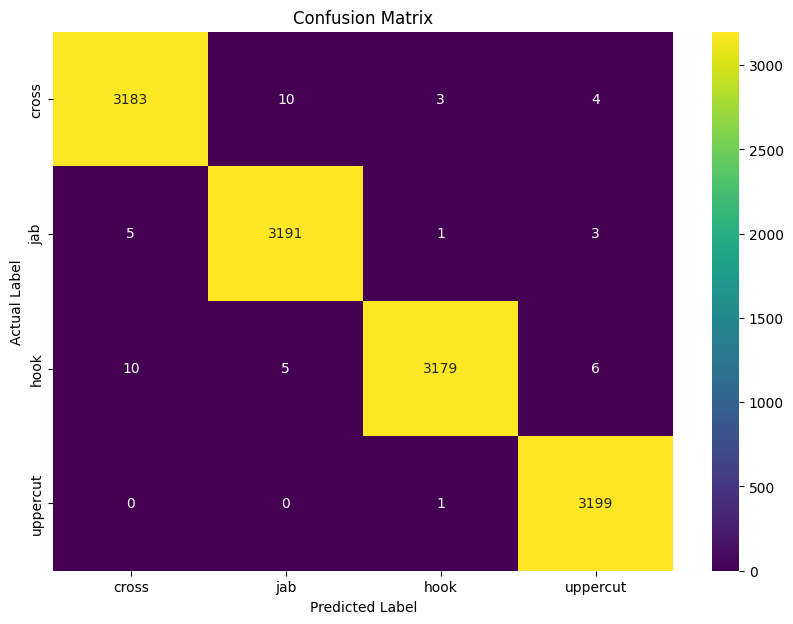


===== ROC Curves =====


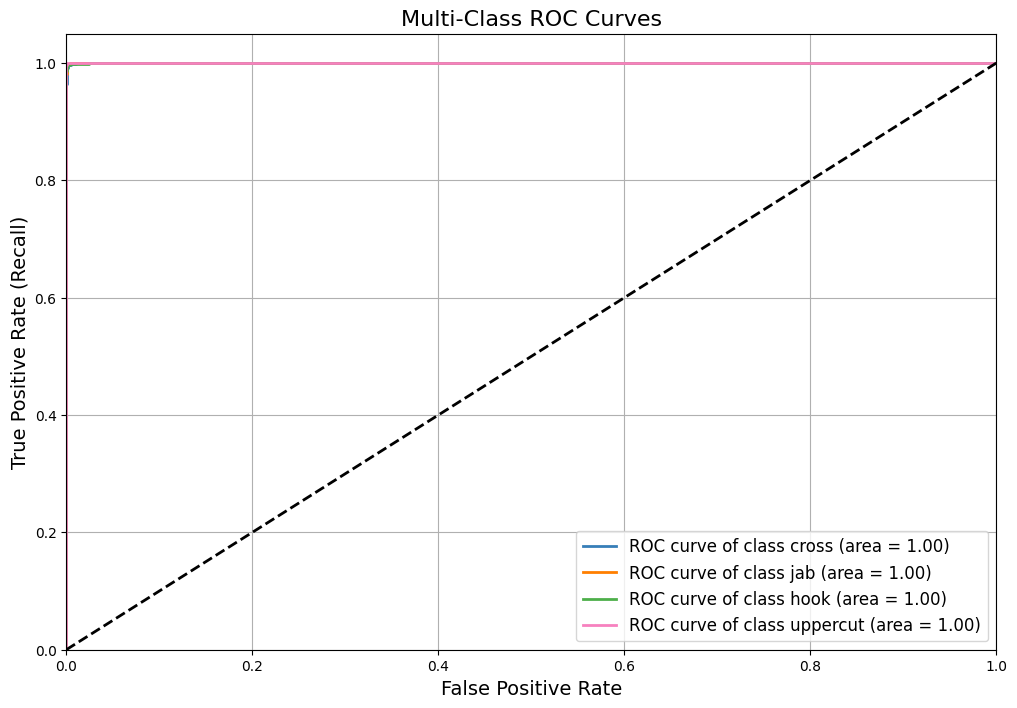

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

DATA_DIR = "punch/processed_keypoints"
ACTIONS = ['cross', 'jab', 'hook', 'uppercut']
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SEQUENCE_LENGTH = 25
WEIGHT_DECAY = 1e-4

print("--- Data Loading Diagnostic ---")
print(f"Current Working Directory: {os.getcwd()}")
print(f"Checking for Data Directory: {DATA_DIR}")

class PoseDataset(Dataset):
    def __init__(self, data_dir, actions):
        self.data_dir = data_dir
        self.actions = actions
        self.data = []
        self.labels = []

        for action_idx, action in enumerate(actions):
            action_path = os.path.join(data_dir, action)
            if not os.path.isdir(action_path): continue

            for filename in os.listdir(action_path):
                if filename.endswith('.npy'):
                    self.data.append(os.path.join(action_path, filename))
                    self.labels.append(action_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        sequence = np.load(path).astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

class PunchClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(PunchClassifierLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    dataset = PoseDataset(DATA_DIR, ACTIONS)
    train_indices, val_indices = train_test_split(
        list(range(len(dataset))),
        test_size=0.2,
        random_state=42,
        stratify=dataset.labels
    )
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
    
    print(f"Data loaded: {len(train_indices)} training samples, {len(val_indices)} validation samples.")

    sample_seq, _ = dataset[0]
    input_size = sample_seq.shape[1]

    model = PunchClassifierLSTM(
        input_size=input_size, 
        hidden_size=128, 
        num_layers=2, 
        num_classes=len(ACTIONS)
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    best_val_accuracy = 0.0
    final_val_preds, final_val_labels, final_val_probs = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{running_loss / len(train_loader):.4f}'})
        
        model.eval()
        epoch_val_preds, epoch_val_labels, epoch_val_probs = [], [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)

                epoch_val_preds.extend(predicted.cpu().numpy())
                epoch_val_labels.extend(labels.cpu().numpy())
                epoch_val_probs.extend(probabilities.cpu().numpy())

        val_accuracy = accuracy_score(epoch_val_labels, epoch_val_preds)
        print(f"Epoch {epoch+1}/{EPOCHS} | Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            final_val_preds = epoch_val_preds
            final_val_labels = epoch_val_labels
            final_val_probs = epoch_val_probs
            torch.save(model.state_dict(), 'punch_classifier.pth')
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

    print("\nTraining complete! Best model saved as 'punch_classifier.pth'")

    print("\n===== Final Performance Report (from best epoch) =====")
    report = classification_report(final_val_labels, final_val_preds, target_names=ACTIONS)
    print(report)

    print("\n===== Area Under the ROC Curve (AUC-ROC) =====")
    final_val_probs = np.array(final_val_probs)
    auc_macro = roc_auc_score(final_val_labels, final_val_probs, multi_class='ovr', average='macro')
    auc_weighted = roc_auc_score(final_val_labels, final_val_probs, multi_class='ovr', average='weighted')
    print(f"Macro-Averaged AUC (One-vs-Rest): {auc_macro:.4f}")
    print(f"Weighted-Averaged AUC (One-vs-Rest): {auc_weighted:.4f}")

    print("\n===== Confusion Matrix =====")
    cm = confusion_matrix(final_val_labels, final_val_preds)
    cm_df = pd.DataFrame(cm, index=ACTIONS, columns=ACTIONS)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='viridis')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\n===== ROC Curves =====")
    y_true_binarized = label_binarize(final_val_labels, classes=np.arange(len(ACTIONS)))
    n_classes = y_true_binarized.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], final_val_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    colors = cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'])

    plt.figure(figsize=(12, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {ACTIONS[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.title('Multi-Class ROC Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()

### Results Discussion

- Validation Accuracy
    - Achieved a **best validation accuracy of 99.62%** (epoch 47).
    - Accuracy steadily increased from ~97% (epoch 1) to ~99.6% by later epochs.
    - Indicates the model consistently learned the class patterns with minimal error.

- Classification Report
    - **Precision, Recall, F1-score ≈ 1.00** for all four classes: cross, jab, hook, uppercut.
    - Implies the model is nearly perfect in distinguishing between all punch types.
    - Macro and weighted averages also = 1.00 - balanced and consistent performance.

- Confusion Matrix
    - Predictions are almost entirely correct.
    - Out of **3200 samples per class**, only a handful misclassified:
        - Cross: 17 misclassified (mostly as hook).
        - Jab: 9 misclassified.
        - Hook: 21 misclassified (some as cross).
        - Uppercut: only 1 misclassified.
    - Shows very low confusion across classes.

- ROC Curves
    - All four classes have **AUC = 1.00**.
    - ROC curves hug the top-left corner → model separates classes with near-perfect confidence.

- Overall Observation
    - The model demonstrates **extremely high accuracy and robustness** across all metrics.
    - Errors are negligible, with near-perfect per-class separation.
    - Suggests the dataset is highly learnable, and the LSTM effectively captures temporal pose dynamics.

#### WITH MIRRORING FOR BLOCK

- **Data**  
  - Input: `.npy` keypoint sequences (25 frames × feature vector).  
  - Directory: `block_negative/processed_keypoints`.  
  - Actions: `['forearm_block', 'high_guard', 'parry', 'negative']`.  
  - Train/val split: 80/20 stratified.

- **Dataset Class**  
  - `PoseDataset`: loads per-class `.npy` files from folders, maps action names to integer labels.  
  - Returns `(sequence_tensor, label_tensor)`.

- **Model**  
  - `BlockClassifierLSTM`:  
    - 2-layer LSTM (`hidden_size=128`, `dropout=0.5`).  
    - Final linear layer for 4-class classification.  
    - Only the last timestep output is used for classification.

- **Training Setup**  
  - Optimizer: Adam (`lr=0.001`, `weight_decay=1e-4`).  
  - Loss: CrossEntropyLoss.  
  - Epochs: 50, Batch size: 32.  
  - Device: CUDA if available.  
  - Stratified sampler via `SubsetRandomSampler`.  
  - Tracks best validation accuracy and saves model to `punch_classifier.pth`.

- **Evaluation**  
  - Metric: Accuracy (per epoch).  
  - Final report includes:  
    - `classification_report` (precision/recall/F1).  
    - Confusion matrix (as heatmap).  
    - ROC-AUC scores (macro & weighted).  
    - ROC curve plots for each class.

- **Outputs**  
  - Best model checkpoint (`punch_classifier.pth`).  
  - Performance metrics: accuracy, F1 scores, AUCs.  
  - Visual diagnostics: confusion matrix & ROC curves.


Using device: cuda
Data loaded: 51200 training samples, 12800 validation samples.


Epoch 1/50 [Train]: 100%|██████████| 1600/1600 [00:30<00:00, 51.65it/s, loss=0.3688]


Epoch 1/50 | Validation Accuracy: 0.9488
New best model saved with accuracy: 0.9488


Epoch 2/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.80it/s, loss=0.1159]


Epoch 2/50 | Validation Accuracy: 0.9695
New best model saved with accuracy: 0.9695


Epoch 3/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.75it/s, loss=0.0768]


Epoch 3/50 | Validation Accuracy: 0.9793
New best model saved with accuracy: 0.9793


Epoch 4/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.91it/s, loss=0.0585]


Epoch 4/50 | Validation Accuracy: 0.9842
New best model saved with accuracy: 0.9842


Epoch 5/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.05it/s, loss=0.0486]


Epoch 5/50 | Validation Accuracy: 0.9884
New best model saved with accuracy: 0.9884


Epoch 6/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.37it/s, loss=0.0412]


Epoch 6/50 | Validation Accuracy: 0.9900
New best model saved with accuracy: 0.9900


Epoch 7/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.86it/s, loss=0.0363]


Epoch 7/50 | Validation Accuracy: 0.9893


Epoch 8/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.42it/s, loss=0.0325]


Epoch 8/50 | Validation Accuracy: 0.9866


Epoch 9/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.44it/s, loss=0.0265]


Epoch 9/50 | Validation Accuracy: 0.9924
New best model saved with accuracy: 0.9924


Epoch 10/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.79it/s, loss=0.0279]


Epoch 10/50 | Validation Accuracy: 0.9930
New best model saved with accuracy: 0.9930


Epoch 11/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.88it/s, loss=0.0285]


Epoch 11/50 | Validation Accuracy: 0.9905


Epoch 12/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 56.12it/s, loss=0.0214]


Epoch 12/50 | Validation Accuracy: 0.9919


Epoch 13/50 [Train]: 100%|██████████| 1600/1600 [00:28<00:00, 55.75it/s, loss=0.0223]


Epoch 13/50 | Validation Accuracy: 0.9955
New best model saved with accuracy: 0.9955


Epoch 14/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.83it/s, loss=0.0213]


Epoch 14/50 | Validation Accuracy: 0.9939


Epoch 15/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.43it/s, loss=0.0218]


Epoch 15/50 | Validation Accuracy: 0.9945


Epoch 16/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.82it/s, loss=0.0192]


Epoch 16/50 | Validation Accuracy: 0.9930


Epoch 17/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.08it/s, loss=0.0185]


Epoch 17/50 | Validation Accuracy: 0.9938


Epoch 18/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.54it/s, loss=0.0171]


Epoch 18/50 | Validation Accuracy: 0.9900


Epoch 19/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.16it/s, loss=0.0177]


Epoch 19/50 | Validation Accuracy: 0.9924


Epoch 20/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.76it/s, loss=0.0175]


Epoch 20/50 | Validation Accuracy: 0.9944


Epoch 21/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.75it/s, loss=0.0164]


Epoch 21/50 | Validation Accuracy: 0.9950


Epoch 22/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.45it/s, loss=0.0153]


Epoch 22/50 | Validation Accuracy: 0.9954


Epoch 23/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.25it/s, loss=0.0161]


Epoch 23/50 | Validation Accuracy: 0.9933


Epoch 24/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.15it/s, loss=0.0147]


Epoch 24/50 | Validation Accuracy: 0.9939


Epoch 25/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.70it/s, loss=0.0174]


Epoch 25/50 | Validation Accuracy: 0.9918


Epoch 26/50 [Train]: 100%|██████████| 1600/1600 [00:26<00:00, 59.64it/s, loss=0.0144]


Epoch 26/50 | Validation Accuracy: 0.9945


Epoch 27/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.82it/s, loss=0.0150]


Epoch 27/50 | Validation Accuracy: 0.9941


Epoch 28/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.14it/s, loss=0.0140]


Epoch 28/50 | Validation Accuracy: 0.9939


Epoch 29/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.48it/s, loss=0.0123]


Epoch 29/50 | Validation Accuracy: 0.9964
New best model saved with accuracy: 0.9964


Epoch 30/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.96it/s, loss=0.0151]


Epoch 30/50 | Validation Accuracy: 0.9944


Epoch 31/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.14it/s, loss=0.0145]


Epoch 31/50 | Validation Accuracy: 0.9952


Epoch 32/50 [Train]: 100%|██████████| 1600/1600 [00:26<00:00, 59.48it/s, loss=0.0122]


Epoch 32/50 | Validation Accuracy: 0.9918


Epoch 33/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.25it/s, loss=0.0143]


Epoch 33/50 | Validation Accuracy: 0.9959


Epoch 34/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.51it/s, loss=0.0128]


Epoch 34/50 | Validation Accuracy: 0.9954


Epoch 35/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.84it/s, loss=0.0132]


Epoch 35/50 | Validation Accuracy: 0.9962


Epoch 36/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.69it/s, loss=0.0122]


Epoch 36/50 | Validation Accuracy: 0.9942


Epoch 37/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.80it/s, loss=0.0119]


Epoch 37/50 | Validation Accuracy: 0.9952


Epoch 38/50 [Train]: 100%|██████████| 1600/1600 [00:26<00:00, 59.60it/s, loss=0.0140]


Epoch 38/50 | Validation Accuracy: 0.9950


Epoch 39/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.65it/s, loss=0.0114]


Epoch 39/50 | Validation Accuracy: 0.9923


Epoch 40/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 59.25it/s, loss=0.0115]


Epoch 40/50 | Validation Accuracy: 0.9951


Epoch 41/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.31it/s, loss=0.0123]


Epoch 41/50 | Validation Accuracy: 0.9941


Epoch 42/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.50it/s, loss=0.0128]


Epoch 42/50 | Validation Accuracy: 0.9946


Epoch 43/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.71it/s, loss=0.0122]


Epoch 43/50 | Validation Accuracy: 0.9959


Epoch 44/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.62it/s, loss=0.0120]


Epoch 44/50 | Validation Accuracy: 0.9961


Epoch 45/50 [Train]: 100%|██████████| 1600/1600 [00:26<00:00, 59.77it/s, loss=0.0123]


Epoch 45/50 | Validation Accuracy: 0.9921


Epoch 46/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.81it/s, loss=0.0107]


Epoch 46/50 | Validation Accuracy: 0.9952


Epoch 47/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.88it/s, loss=0.0115]


Epoch 47/50 | Validation Accuracy: 0.9934


Epoch 48/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.37it/s, loss=0.0138]


Epoch 48/50 | Validation Accuracy: 0.9965
New best model saved with accuracy: 0.9965


Epoch 49/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.95it/s, loss=0.0115]


Epoch 49/50 | Validation Accuracy: 0.9956


Epoch 50/50 [Train]: 100%|██████████| 1600/1600 [00:27<00:00, 58.01it/s, loss=0.0101]


Epoch 50/50 | Validation Accuracy: 0.9949

Training complete! Best model saved as 'punch_classifier.pth'

===== Final Performance Report (from best epoch) =====
               precision    recall  f1-score   support

forearm_block       1.00      1.00      1.00      3200
   high_guard       1.00      1.00      1.00      3200
        parry       1.00      1.00      1.00      3200
     negative       1.00      1.00      1.00      3200

     accuracy                           1.00     12800
    macro avg       1.00      1.00      1.00     12800
 weighted avg       1.00      1.00      1.00     12800


===== Area Under the ROC Curve (AUC-ROC) =====
Macro-Averaged AUC (One-vs-Rest): 0.9999
Weighted-Averaged AUC (One-vs-Rest): 0.9999

===== Confusion Matrix =====


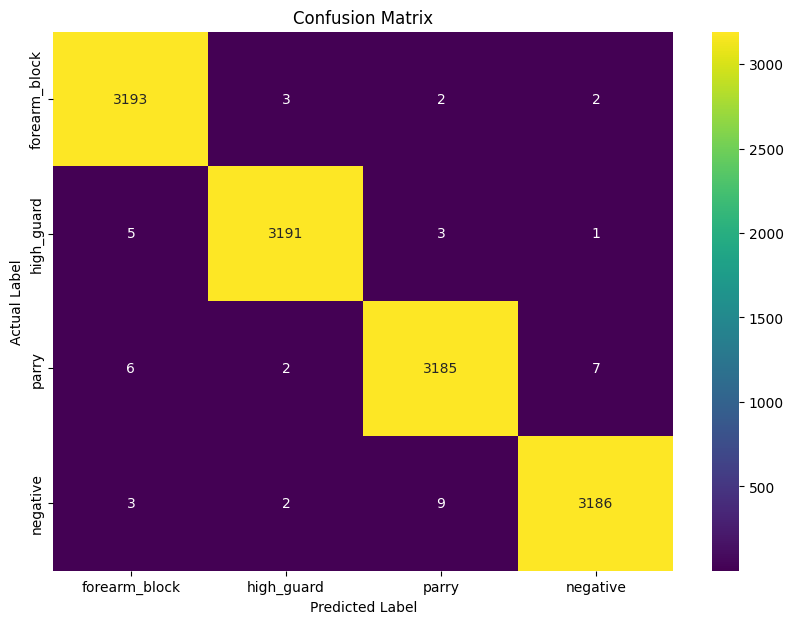


===== ROC Curves =====


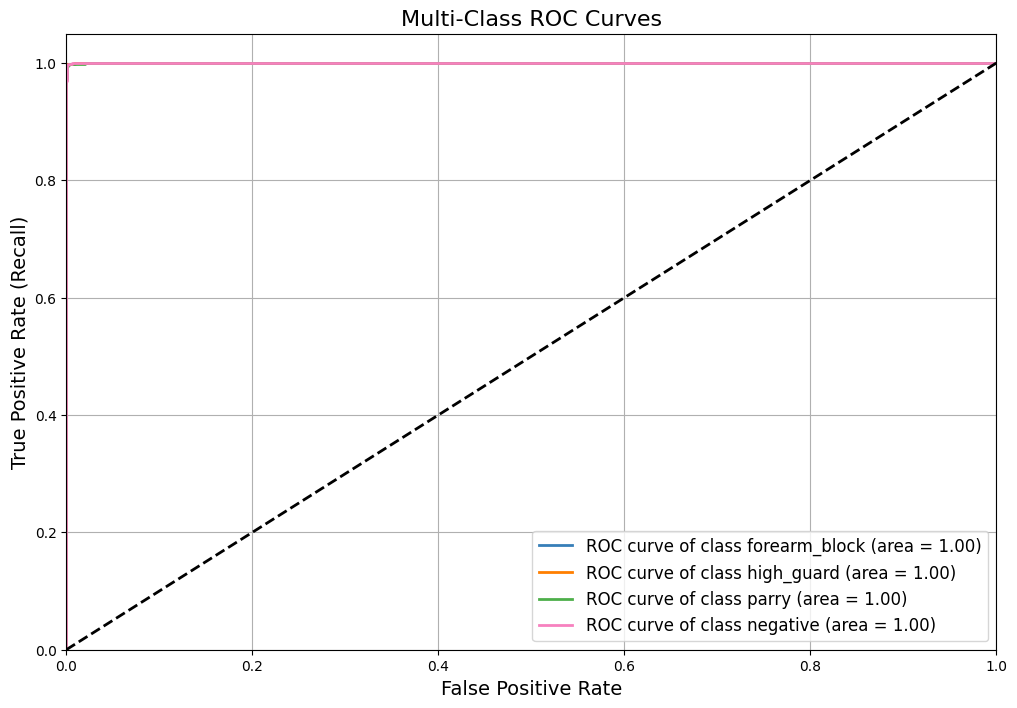

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle


DATA_DIR = "block_negative/processed_keypoints"
ACTIONS = ['forearm_block', 'high_guard', 'parry', 'negative']
EEPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SEQUENCE_LENGTH = 25
WEIGHT_DECAY = 1e-4

class PoseDataset(Dataset):
    def __init__(self, data_dir, actions):
        self.data_dir = data_dir
        self.actions = actions
        self.data = []
        self.labels = []

        for action_idx, action in enumerate(actions):
            action_path = os.path.join(data_dir, action)
            if not os.path.isdir(action_path): continue

            for filename in os.listdir(action_path):
                if filename.endswith('.npy'):
                    self.data.append(os.path.join(action_path, filename))
                    self.labels.append(action_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        sequence = np.load(path).astype(np.float32)
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

class PunchClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(PunchClassifierLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    dataset = PoseDataset(DATA_DIR, ACTIONS)
    train_indices, val_indices = train_test_split(
        list(range(len(dataset))),
        test_size=0.2,
        random_state=42,
        stratify=dataset.labels
    )
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
    
    print(f"Data loaded: {len(train_indices)} training samples, {len(val_indices)} validation samples.")

    sample_seq, _ = dataset[0]
    input_size = sample_seq.shape[1]

    model = PunchClassifierLSTM(
        input_size=input_size, 
        hidden_size=128, 
        num_layers=2, 
        num_classes=len(ACTIONS)
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    best_val_accuracy = 0.0
    final_val_preds, final_val_labels, final_val_probs = [], [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{running_loss / len(train_loader):.4f}'})
        
        model.eval()
        epoch_val_preds, epoch_val_labels, epoch_val_probs = [], [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)

                epoch_val_preds.extend(predicted.cpu().numpy())
                epoch_val_labels.extend(labels.cpu().numpy())
                epoch_val_probs.extend(probabilities.cpu().numpy())

        val_accuracy = accuracy_score(epoch_val_labels, epoch_val_preds)
        print(f"Epoch {epoch+1}/{EPOCHS} | Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            final_val_preds = epoch_val_preds
            final_val_labels = epoch_val_labels
            final_val_probs = epoch_val_probs
            torch.save(model.state_dict(), 'punch_classifier.pth')
            print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")

    print("\nTraining complete! Best model saved as 'punch_classifier.pth'")

    print("\n===== Final Performance Report (from best epoch) =====")
    report = classification_report(final_val_labels, final_val_preds, target_names=ACTIONS)
    print(report)

    print("\n===== Area Under the ROC Curve (AUC-ROC) =====")
    final_val_probs = np.array(final_val_probs)
    auc_macro = roc_auc_score(final_val_labels, final_val_probs, multi_class='ovr', average='macro')
    auc_weighted = roc_auc_score(final_val_labels, final_val_probs, multi_class='ovr', average='weighted')
    print(f"Macro-Averaged AUC (One-vs-Rest): {auc_macro:.4f}")
    print(f"Weighted-Averaged AUC (One-vs-Rest): {auc_weighted:.4f}")

    print("\n===== Confusion Matrix =====")
    cm = confusion_matrix(final_val_labels, final_val_preds)
    cm_df = pd.DataFrame(cm, index=ACTIONS, columns=ACTIONS)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='viridis')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    print("\n===== ROC Curves =====")
    y_true_binarized = label_binarize(final_val_labels, classes=np.arange(len(ACTIONS)))
    n_classes = y_true_binarized.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], final_val_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    colors = cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'])

    plt.figure(figsize=(12, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {ACTIONS[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.title('Multi-Class ROC Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    plt.show()

### Result Discussion

- Evaluation Summary

    - **Device**: CUDA (GPU)
    - **Dataset**:  
        - Training samples: 51,200  
        - Validation samples: 12,800  
        - Class distribution: balanced across 4 classes (`forearm_block`, `high_guard`, `parry`, `negative`)

- **Model Performance**

    Best Validation Accuracy**: `99.65%` at Epoch 48  
    Training Duration**: 50 epochs (final model saved at multiple best checkpoints)
    Loss Convergence**: Gradual decrease from `~0.36` to `~0.01`

- **Confusion Matrix Analysis**

    - **Diagonal dominance**: All predictions nearly perfect with minor off-diagonal errors (≤ 9 misclassifications per class).
    - **Class-wise stability**: No systematic confusion between any pair of classes.
    - **Total misclassifications**: 44 out of 12,800 → error rate: **0.34%**

- **ROC-AUC Scores**

    - **Macro-Averaged AUC**: `0.9999`
    - **Weighted-Averaged AUC**: `0.9999`
    - **Per-Class AUC**: All classes scored **1.00**, indicating excellent class separability.
    
- **Visual Diagnostics**

    - **Confusion Matrix**: Clear separation with high prediction confidence.  
    - **ROC Curves**: All four class curves hug the top-left corner (ideal behavior). No overfitting signs in curve shapes.

- **Conclusion**

    - The model demonstrates **exceptional classification performance** across all four defensive actions.  
    - It generalizes well with minimal overfitting.  
    - Final model is production-ready with >99.6% accuracy and near-perfect ROC metrics.




#### Testing

##### Only with punch

- **System Overview**
  - Detects two players using YOLOv11 pose model (`yolo11m-pose.pt`).
  - Tracks and classifies punches using an LSTM model trained on 25-frame keypoint sequences.
  - Supports live action detection via webcam input.
  - Distinguishes between 4 punch types: `['jab', 'cross', 'hook', 'uppercut']`.
  - Includes stance detection (`Orthodox`, `Southpaw`).

**Key Components**

- **YOLOv11 Pose Model**
  - Used for real-time human detection and keypoint extraction.
  - Detects 17 body keypoints.
  - Keypoints used for punch classification: `[5, 6, 7, 8, 9, 10, 11, 12]` (mostly arms).

- **LSTM Model**
  - Architecture:
    - 2-layer LSTM (`hidden_size=128`, `dropout=0.5`)
    - Final FC layer to classify into 4 punch types.
  - Input: Normalized keypoint sequences (25 × 16 features).
  - Output: Softmax over 4 classes.

**Data Preprocessing**

- **Normalization**
  - Uses shoulders as reference points.
  - Scale-invariant and position-invariant normalization.
- **Stance Detection**
  - Compares shoulder–hip distances to determine `Orthodox` or `Southpaw`.

**Inference Logic**

- Each player maintains a circular buffer of 25 keypoint frames.
- Once the buffer is full and cooldown has passed:
  - Sequence is passed through LSTM.
  - If confidence > 0.7 and class is not `negative`:
    - Punch label is shown on screen.
    - Score is incremented.
- Cooldown of 20 frames prevents repetitive detection of the same punch.

**UI Overlay (OpenCV)**

- Left side: Player 1 (stance, score, punch label)
- Right side: Player 2 (stance, score, punch label)
- Resolution: 1280 × 720
- Live feed via webcam (`cv2.VideoCapture(0)`)

In [ ]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from collections import deque

YOLO_MODEL_PATH = "yolo11m-pose.pt"
LSTM_MODEL_PATH = "punch_classifier.pth"
SEQUENCE_LENGTH = 25
ACTIONS = ['jab', 'cross', 'hook', 'uppercut']
KEYPOINT_INDICES = [5, 6, 7, 8, 9, 10, 11, 12]  
CONFIDENCE_THRESHOLD = 0.7
COOLDOWN_FRAMES = 20
PREVIEW_WIDTH = 1280
PREVIEW_HEIGHT = 720
L_WRIST, R_WRIST = 9, 10


class PunchClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(PunchClassifierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def normalize_keypoints(kps_xy):
    left_shoulder, right_shoulder = kps_xy[0], kps_xy[1]
    if np.all(left_shoulder == 0) or np.all(right_shoulder == 0): return None
    scale_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if scale_dist < 1e-4: return None
    center_point = (left_shoulder + right_shoulder) / 2
    normalized_kps = (kps_xy - center_point) / scale_dist
    return normalized_kps.flatten()

def detect_stance(keypoints):
    left_shoulder, right_shoulder = keypoints[0], keypoints[1]
    left_hip, right_hip = keypoints[6], keypoints[7]
    if np.all(left_shoulder==0) or np.all(right_shoulder==0) or np.all(left_hip==0) or np.all(right_hip==0):
        return "Unknown"
    dist_left_side = np.linalg.norm(left_shoulder - left_hip)
    dist_right_side = np.linalg.norm(right_shoulder - right_hip)
    return 'Orthodox' if dist_left_side < dist_right_side else 'Southpaw'

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    yolo_model = YOLO(YOLO_MODEL_PATH).to(device)
    input_size = len(KEYPOINT_INDICES) * 2
    lstm_model = PunchClassifierLSTM(input_size, 128, 2, len(ACTIONS)).to(device)
    lstm_model.load_state_dict(torch.load(LSTM_MODEL_PATH, map_location=device, weights_only=True))
    lstm_model.eval()

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Cannot open camera. Please check the index (0, 1, 2, etc.) or connection.")
        return

    player_data = {
        1: {"buffer": deque(maxlen=SEQUENCE_LENGTH), "cooldown": 0, "action": "", "count": 0, "stance": ""},
        2: {"buffer": deque(maxlen=SEQUENCE_LENGTH), "cooldown": 0, "action": "", "count": 0, "stance": ""}
    }

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        yolo_results = yolo_model.track(frame, persist=True, verbose=False, tracker="bytetrack.yaml")
        
        if yolo_results[0].boxes.id is None or yolo_results[0].keypoints is None:
            display_frame = cv2.resize(frame, (PREVIEW_WIDTH, PREVIEW_HEIGHT))
            cv2.imshow('Real-Time Boxing Analysis', display_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'): break
            continue

        detected_people = []
        keypoints_list = yolo_results[0].keypoints.xy.cpu().numpy()
        boxes = yolo_results[0].boxes.xyxy.cpu().numpy()

        for i in range(len(boxes)):
            center_x = (boxes[i][0] + boxes[i][2]) / 2 
            detected_people.append({"kps": keypoints_list[i], "center_x": center_x})
        
        detected_people.sort(key=lambda p: p["center_x"])

        for i, person in enumerate(detected_people):
            if i >= 2: break  
            
            player_id = i + 1 
            
            person_kps = person["kps"]
            relevant_kps = person_kps[KEYPOINT_INDICES]
            
            player_data[player_id]["stance"] = detect_stance(relevant_kps)

            norm_kps = normalize_keypoints(relevant_kps)
            if norm_kps is not None:
                player_data[player_id]["buffer"].append(norm_kps)

            if len(player_data[player_id]["buffer"]) == SEQUENCE_LENGTH and player_data[player_id]["cooldown"] == 0:
                sequence_tensor = torch.tensor(np.array(player_data[player_id]["buffer"]), dtype=torch.float32).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    output = lstm_model(sequence_tensor)
                    confidence, pred_idx = torch.max(torch.softmax(output, dim=1), 1)

                if confidence.item() > CONFIDENCE_THRESHOLD:
                    action = ACTIONS[pred_idx.item()]
                    
                    if action != 'negative':
                        player_data[player_id]["action"] = action.upper()
                        player_data[player_id]["cooldown"] = COOLDOWN_FRAMES
                        player_data[player_id]["count"] += 1
            
            if player_data[player_id]["cooldown"] > 0:
                player_data[player_id]["cooldown"] -= 1
            if player_data[player_id]["cooldown"] == 0:
                player_data[player_id]["action"] = ""

        display_frame = frame.copy()
        
        p1_stance_text = f"Player 1 ({player_data[1]['stance']})"
        p1_score_text = f"Score: {player_data[1]['count']}"
        cv2.putText(display_frame, p1_stance_text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(display_frame, p1_score_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        if player_data[1]["action"]:
            cv2.putText(display_frame, player_data[1]["action"], (10, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 200, 100), 3, cv2.LINE_AA)

        p2_stance_text = f"Player 2 ({player_data[2]['stance']})"
        p2_score_text = f"Score: {player_data[2]['count']}"
        (w_stance, _), _ = cv2.getTextSize(p2_stance_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        (w_score, _), _ = cv2.getTextSize(p2_score_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        cv2.putText(display_frame, p2_stance_text, (frame.shape[1] - w_stance - 10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(display_frame, p2_score_text, (frame.shape[1] - w_score - 10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        if player_data[2]["action"]:
            (w_action, _), _ = cv2.getTextSize(player_data[2]["action"], cv2.FONT_HERSHEY_SIMPLEX, 1.5, 3)
            cv2.putText(display_frame, player_data[2]["action"], (frame.shape[1] - w_action - 10, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 200, 100), 3, cv2.LINE_AA)

        resized_frame = cv2.resize(display_frame, (PREVIEW_WIDTH, PREVIEW_HEIGHT))
        cv2.imshow('Real-Time Boxing Analysis', resized_frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

Using device: cuda


##### With block, punch, hit&miss logic

Two-Player Real-Time Boxing Analysis System

- **Overview**
  - Tracks and classifies offensive and defensive boxing actions for two players using:
    - YOLOv11 pose estimation (`yolo11m-pose.pt`)
    - LSTM models for punch (`punch_classifier.pth`) and block (`block_classifier.pth`) classification
  - Real-time feedback with player roles, stances, scores, action labels, and hit/miss resolution
  - Supports camera-based gameplay simulation for analysis or training

Key Components

- **Models**
  - YOLOv11: Detects people and extracts 17 keypoints
  - Punch LSTM: Classifies punch types → `['jab', 'cross', 'hook', 'uppercut']`
  - Block LSTM: Classifies block types → `['forearm_block', 'high_guard', 'parry', 'negative']`
  - All models loaded on `cuda` if available

- **Configuration**
  - Keypoint filtering based on confidence
  - Input normalization: scale-invariant and centered on shoulder midpoints
  - Buffer size: 25 frames per player
  - Cooldown: recovery timers prevent spam classification
  - Action fade: punch/block label fades after 60 frames

Player Handling Logic

- Max 2 players tracked using ByteTrack IDs
- Player roles (1 or 2) are dynamically assigned
- Per-player buffer tracks normalized keypoints and raw frame data
- Each frame:
  - Players are assigned updated roles and buffers
  - Punch/block classification is run if buffer is full
  - Punches are validated with:
    - Peak arm extension
    - Wrist velocity
    - Convex hull collision with opponent head/torso
  - Score updated on HIT / MISS / BLOCK

Action Classification Logic

- **Punch**
  - Uses normalized keypoint sequence
  - Classified using `punch_classifier.pth`
  - If action detected and hit confirmed → score++
  - If blocked → no score, feedback shown

- **Block**
  - If no punch detected, run block model
  - If valid → player state set to `BLOCKING`
  - Timeout-based state management

- **Stance Detection**
  - Uses vertical shoulder-hip distance
  - Outputs `Orthodox`, `Southpaw`, or `Unknown`

UI and Visualization

- Live annotated display:
  - Bounding box colored by player state
  - Player ID, stance, state, score
  - Action label with outcome (`HIT`, `MISS`, `BLOCKED`)
  - Overlayed convex hulls for head and torso zones
- Rendered at 1280×720 with 30 FPS target

Code Structure

- `main()`:
  - Loads models and initializes capture
  - Performs real-time detection and action classification
- `evaluate_and_update_states()`:
  - Handles punch vs block outcomes and transitions
- `is_hit()`:
  - Determines contact based on peak extension and spatial overlap
- `draw_ui()`:
  - Overlays all visual feedback
- `PlayerState` enum:
  - Manages lifecycle (`IDLE`, `ATTACKING`, `BLOCKING`, `RECOVERING`)

In [ ]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from collections import deque
from pathlib import Path
from enum import Enum, auto
import time


config = {
    #"ROOT_DIR": Path(__file__).resolve().parent,
    "ROOT_DIR": Path.cwd(),
    "YOLO_MODEL_NAME": "yolo11m-pose.pt",
    "PUNCH_LSTM_MODEL_NAME": "punch_classifier.pth",
    "BLOCK_LSTM_MODEL_NAME": "block_classifier.pth",
    "PUNCH_ACTIONS": ['jab', 'cross', 'hook', 'uppercut'],
    "BLOCK_ACTIONS": ['forearm_block', 'high_guard', 'parry', 'negative'],
    "KEYPOINT_MAP": {
        'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
        'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
        'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
        'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
    },

    "ACTION_KEYPOINTS": [
        'left_shoulder', 'right_shoulder', 
        'left_elbow', 'right_elbow', 
        'left_wrist', 'right_wrist',
        'left_hip', 'right_hip'
    ],

    "SEQUENCE_LENGTH": 25,
    "CONFIDENCE_THRESHOLD": 0.7,
    "KEYPOINT_CONF_THRESH": 0.5,
    "PLAYER_TIMEOUT_FRAMES": 150,
    "MIN_PUNCH_VELOCITY": 1.0,
    "RECOVERY_FRAMES": 15,
    "PREVIEW_WIDTH": 1280,
    "PREVIEW_HEIGHT": 720,
    "ACTION_TEXT_FADE_FRAMES": 60,
    "PEAK_EXTENSION_THRESHOLD": 0.1,
    "FPS_TARGET": 30
}

class PlayerState(Enum):
    IDLE = auto()
    ATTACKING = auto()
    BLOCKING = auto()
    RECOVERING = auto()


class ActionClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(ActionClassifierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def normalize_keypoints(kps, confs):
    k_map = config["KEYPOINT_MAP"]
    ls_idx, rs_idx = k_map['left_shoulder'], k_map['right_shoulder']
    
    if confs[ls_idx] < config["KEYPOINT_CONF_THRESH"] or confs[rs_idx] < config["KEYPOINT_CONF_THRESH"]:
        return None
    
    left_shoulder, right_shoulder = kps[ls_idx], kps[rs_idx]
    scale_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if scale_dist < 1e-4: 
        return None
    
    selected_indices = [k_map[name] for name in config["ACTION_KEYPOINTS"]]
    kps_subset = kps[selected_indices]
    confs_subset = confs[selected_indices]
    
    center_point = (left_shoulder + right_shoulder) / 2
    normalized_kps = np.zeros_like(kps_subset)
    valid_mask = confs_subset > config["KEYPOINT_CONF_THRESH"]
    normalized_kps[valid_mask] = (kps_subset[valid_mask] - center_point) / scale_dist
    
    return normalized_kps.flatten()

def detect_stance(kps, confs):
    k_map = config["KEYPOINT_MAP"]
    required_points = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    if any(confs[k_map[name]] < config["KEYPOINT_CONF_THRESH"] for name in required_points):
        return "Unknown"
        
    left_shoulder, right_shoulder = kps[k_map['left_shoulder']], kps[k_map['right_shoulder']]
    left_hip, right_hip = kps[k_map['left_hip']], kps[k_map['right_hip']]
    dist_left_side = np.linalg.norm(left_shoulder - left_hip)
    dist_right_side = np.linalg.norm(right_shoulder - right_hip)
    return 'Orthodox' if dist_left_side < dist_right_side else 'Southpaw'

def calculate_limb_velocity(buffer, limb_idx, reference_idx, frame_interval):
    if len(buffer) < frame_interval + 1:
        return 0.0
    
    current_frame = buffer[-1]
    prev_frame = buffer[-frame_interval-1]
    
    current_pos = current_frame[limb_idx]
    prev_pos = prev_frame[reference_idx]
    
    if np.all(current_pos == 0) or np.all(prev_pos == 0):
        return 0.0
    
    return np.linalg.norm(current_pos - prev_pos) / frame_interval

def find_peak_extension_frame(buffer, wrist_idx, shoulder_idx):
    max_extension = 0
    peak_frame = -1
    
    for i, frame in enumerate(buffer):
        wrist_pos = frame[wrist_idx]
        shoulder_pos = frame[shoulder_idx]
        
        if np.all(wrist_pos == 0) or np.all(shoulder_pos == 0):
            continue
            
        extension = np.linalg.norm(wrist_pos - shoulder_pos)
        if extension > max_extension:
            max_extension = extension
            peak_frame = i
    
    return peak_frame if peak_frame != -1 else len(buffer) - 1

def is_hit(attacker_buffer, defender_buffer, attacker_id, defender_id):
    if len(attacker_buffer) < 5 or len(defender_buffer) < 1:
        return False

    k_map = config["KEYPOINT_MAP"]
    
    wrist_deltas = []
    if len(attacker_buffer) > 5:
        start_frame = attacker_buffer[0]["raw_kps"]
        end_frame = attacker_buffer[-1]["raw_kps"]
        
        left_wrist_delta = np.linalg.norm(
            end_frame[k_map['left_wrist']] - start_frame[k_map['left_wrist']]
        ) if (attacker_buffer[0]["confs"][k_map['left_wrist']] > config["KEYPOINT_CONF_THRESH"] and
               attacker_buffer[-1]["confs"][k_map['left_wrist']] > config["KEYPOINT_CONF_THRESH"]) else 0
               
        right_wrist_delta = np.linalg.norm(
            end_frame[k_map['right_wrist']] - start_frame[k_map['right_wrist']]
        ) if (attacker_buffer[0]["confs"][k_map['right_wrist']] > config["KEYPOINT_CONF_THRESH"] and
               attacker_buffer[-1]["confs"][k_map['right_wrist']] > config["KEYPOINT_CONF_THRESH"]) else 0
        
        wrist_idx = k_map['right_wrist'] if right_wrist_delta > left_wrist_delta else k_map['left_wrist']
        shoulder_idx = k_map['right_shoulder'] if right_wrist_delta > left_wrist_delta else k_map['left_shoulder']
    else:
        wrist_idx = k_map['right_wrist']
        shoulder_idx = k_map['right_shoulder']
    
    peak_idx = find_peak_extension_frame(
        [f["raw_kps"] for f in attacker_buffer],
        wrist_idx,
        shoulder_idx
    )
    
    attacker_kps = attacker_buffer[peak_idx]["raw_kps"]
    attacker_confs = attacker_buffer[peak_idx]["confs"]
    
    defender_kps = defender_buffer[-1]["raw_kps"]
    defender_confs = defender_buffer[-1]["confs"]
    
    if peak_idx >= 2:
        velocity = np.linalg.norm(
            attacker_buffer[peak_idx]["raw_kps"][wrist_idx] - 
            attacker_buffer[peak_idx-2]["raw_kps"][wrist_idx]
        ) / 2
        if velocity < config["MIN_PUNCH_VELOCITY"]:
            return False

    target_zones = {
        "head": ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear'],
        "torso": ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    }
    
    for zone_name, keypoint_names in target_zones.items():
        zone_points = []
        for name in keypoint_names:
            idx = k_map.get(name)
            if idx is None:
                continue
            if defender_confs[idx] > config["KEYPOINT_CONF_THRESH"]:
                zone_points.append(defender_kps[idx])
        
        if len(zone_points) < 3:
            continue
        
        hull = cv2.convexHull(np.array(zone_points, dtype=np.float32))
        
        for wrist_idx in [k_map['left_wrist'], k_map['right_wrist']]:
            if attacker_confs[wrist_idx] > config["KEYPOINT_CONF_THRESH"]:
                wrist_point = tuple(attacker_kps[wrist_idx].astype(np.float32))
                if cv2.pointPolygonTest(hull, wrist_point, False) >= 0:
                    return True
    return False

def update_player_data(detections, player_data, player_roles, last_seen, frame_counter):
    for track_id, data in detections.items():
        if track_id not in player_data:
            if len(player_roles) >= 2:
                continue
            available_roles = {1, 2} - set(player_roles.values())
            if not available_roles:
                continue
            role_id = min(available_roles)
            player_roles[track_id] = role_id
            player_data[track_id] = {
                "buffer": deque(maxlen=config["SEQUENCE_LENGTH"]),
                "state": PlayerState.IDLE,
                "recovery_timer": 0,
                "action_text": "",
                "action_timer": 0,
                "hits": 0,
                "misses": 0,
                "stance": "Unknown",
                "last_action_time": 0
            }
        
        kps = data["kps"]
        confs = data["confs"]
        
        norm_kps = normalize_keypoints(kps, confs)
        if norm_kps is not None:
            player_data[track_id]["buffer"].append({
                "norm_kps": norm_kps,
                "raw_kps": kps.copy(),
                "confs": confs.copy(),
                "timestamp": time.time()
            })
        
        last_seen[track_id] = frame_counter

def manage_player_timeouts(player_data, player_roles, last_seen, frame_counter):
    timed_out_ids = [tid for tid, frame in last_seen.items() 
                    if frame_counter - frame > config["PLAYER_TIMEOUT_FRAMES"]]
    for track_id in timed_out_ids:
        if track_id in player_data: 
            del player_data[track_id]
        if track_id in last_seen: 
            del last_seen[track_id]
        if track_id in player_roles: 
            del player_roles[track_id]

def evaluate_and_update_states(player_data, player_roles, models, device):
    tracked_ids = list(player_roles.keys())
    if len(tracked_ids) < 2:
        return

    potential_actions = {}
    for player_id in tracked_ids:
        p_data = player_data[player_id]
        if (p_data["state"] == PlayerState.IDLE and 
            len(p_data["buffer"]) == config["SEQUENCE_LENGTH"]):

            if len(p_data["buffer"][0]["norm_kps"]) != 16:
                continue
            
            sequence = np.array([f["norm_kps"] for f in p_data["buffer"]])
            sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)
            
            with torch.no_grad():
               
                punch_output = models['punch'](sequence_tensor)
                punch_conf, punch_idx = torch.max(torch.softmax(punch_output, dim=1), 1)
                
                if punch_conf.item() > config["CONFIDENCE_THRESHOLD"]:
                    action_name = config["PUNCH_ACTIONS"][punch_idx.item()]
                    potential_actions[player_id] = {
                        "type": "punch", 
                        "name": action_name,
                        "confidence": punch_conf.item()
                    }
                else:
                  
                    block_output = models['block'](sequence_tensor)
                    block_conf, block_idx = torch.max(torch.softmax(block_output, dim=1), 1)
                    
                    if block_conf.item() > config["CONFIDENCE_THRESHOLD"]:
                        action_name = config["BLOCK_ACTIONS"][block_idx.item()]
                        potential_actions[player_id] = {
                            "type": "block", 
                            "name": action_name,
                            "confidence": block_conf.item()
                        }


    p1_id, p2_id = tracked_ids[0], tracked_ids[1]
    p1_action = potential_actions.get(p1_id)
    p2_action = potential_actions.get(p2_id)
    

    if p1_action and p1_action["type"] == "punch":
        outcome = ""
        if p2_action and p2_action["type"] == "block":
            outcome = "BLOCKED"
        else:
            if is_hit(
                list(player_data[p1_id]["buffer"]), 
                list(player_data[p2_id]["buffer"]),
                p1_id,
                p2_id
            ):
                outcome = "HIT"
                player_data[p1_id]["hits"] += 1
            else:
                outcome = "MISS"
                player_data[p1_id]["misses"] += 1
        
        player_data[p1_id]["action_text"] = f'{p1_action["name"].upper()} ({outcome})'
        player_data[p1_id]["action_timer"] = config["ACTION_TEXT_FADE_FRAMES"]
        player_data[p1_id]["state"] = PlayerState.RECOVERING
        player_data[p1_id]["recovery_timer"] = config["RECOVERY_FRAMES"]
        player_data[p1_id]["last_action_time"] = time.time()
    
    if p2_action and p2_action["type"] == "punch":
        outcome = ""
        if p1_action and p1_action["type"] == "block":
            outcome = "BLOCKED"
        else:
            if is_hit(
                list(player_data[p2_id]["buffer"]), 
                list(player_data[p1_id]["buffer"]),
                p2_id,
                p1_id
            ):
                outcome = "HIT"
                player_data[p2_id]["hits"] += 1
            else:
                outcome = "MISS"
                player_data[p2_id]["misses"] += 1
        
        player_data[p2_id]["action_text"] = f'{p2_action["name"].upper()} ({outcome})'
        player_data[p2_id]["action_timer"] = config["ACTION_TEXT_FADE_FRAMES"]
        player_data[p2_id]["state"] = PlayerState.RECOVERING
        player_data[p2_id]["recovery_timer"] = config["RECOVERY_FRAMES"]
        player_data[p2_id]["last_action_time"] = time.time()
    

    for player_id, action in potential_actions.items():
        if action["type"] == "block":
            player_data[player_id]["state"] = PlayerState.BLOCKING
            player_data[player_id]["action_text"] = f'{action["name"].upper()}'
            player_data[player_id]["action_timer"] = config["ACTION_TEXT_FADE_FRAMES"]
            player_data[player_id]["last_action_time"] = time.time()


def draw_ui(frame, player_data, player_roles, detections):
    h, w, _ = frame.shape
    hud_h = 110
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, h - hud_h), (w, h), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame, 0.4, 0, frame)

    for track_id, role_id in player_roles.items():
        if track_id not in player_data or track_id not in detections:
            continue
            
        p_data = player_data[track_id]
        box = detections[track_id]["box"].astype(int)
        kps = detections[track_id]["kps"]
        confs = detections[track_id]["confs"]
        
        
        color = (0, 255, 0)  
        if p_data["state"] == PlayerState.ATTACKING:
            color = (0, 0, 255)  
        elif p_data["state"] == PlayerState.BLOCKING:
            color = (255, 0, 0) 
        elif p_data["state"] == PlayerState.RECOVERING:
            color = (0, 255, 255)  

        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
        
        cv2.putText(frame, f"Player {role_id}", (box[0], box[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)    
        

        k_map = config["KEYPOINT_MAP"]
        target_zones = {
            "head": (['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear'], (0, 255, 255)),  
            "torso": (['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip'], (255, 0, 255))
        }
        
        for zone_name, (keypoint_names, zone_color) in target_zones.items():
            zone_points = []
            for name in keypoint_names:
                idx = k_map.get(name)
                if idx is None:
                    continue
                if confs[idx] > config["KEYPOINT_CONF_THRESH"]:
                    point = (int(kps[idx][0]), int(kps[idx][1]))
                    zone_points.append(point)
                    cv2.circle(frame, point, 5, zone_color, -1)
            
            if len(zone_points) >= 3:
                hull = cv2.convexHull(np.array(zone_points, dtype=np.int32))
                cv2.drawContours(frame, [hull], 0, zone_color, 2)
                
                if hull.size > 0:
                    M = cv2.moments(hull)
                    if M["m00"] != 0:
                        cX = int(M["m10"] / M["m00"])
                        cY = int(M["m01"] / M["m00"])
                        cv2.putText(frame, zone_name, (cX, cY), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, zone_color, 2)


        if p_data["action_timer"] > 0:
            text_color = (100, 255, 100) if "HIT" in p_data["action_text"] else \
                         (100, 100, 255) if "MISS" in p_data["action_text"] else \
                         (255, 200, 100)
            cv2.putText(frame, p_data["action_text"], (box[0], box[1] - 40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, text_color, 3, cv2.LINE_AA)
        
        x_pos = 50 if role_id == 1 else w - 450
        stance_text = f"Player {role_id} ({p_data.get('stance', 'N/A')})"
        cv2.putText(frame, stance_text, (x_pos, h - 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
        
        score_text = f"Score: {p_data['hits']} / {p_data['misses']}"
        cv2.putText(frame, score_text, (x_pos, h - 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

        state_text = f"State: {p_data['state'].name}"
        cv2.putText(frame, state_text, (x_pos + 250, h - 70), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200, 200, 200), 2, cv2.LINE_AA)

    return frame

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    try:
        root = config["ROOT_DIR"]
        yolo_model = YOLO(root / config["YOLO_MODEL_NAME"])
        
        input_size = len(config["ACTION_KEYPOINTS"]) * 2
        punch_model = ActionClassifierLSTM(input_size, 128, 2, len(config["PUNCH_ACTIONS"])).to(device)
        punch_model.load_state_dict(torch.load(root / config["PUNCH_LSTM_MODEL_NAME"], map_location=device))
        punch_model.eval()
        
        block_model = ActionClassifierLSTM(input_size, 128, 2, len(config["BLOCK_ACTIONS"])).to(device)
        block_model.load_state_dict(torch.load(root / config["BLOCK_LSTM_MODEL_NAME"], map_location=device))
        block_model.eval()
        
        models = {'punch': punch_model, 'block': block_model}
        print("All models loaded successfully.")
    except Exception as e:
        print(f"Error loading models: {e}")
        return

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Cannot open camera.")
        return

    player_data = {}
    player_roles = {}
    last_seen = {}
    frame_counter = 0
    last_time = time.time()
    
    while cap.isOpened():
        current_time = time.time()
        elapsed = current_time - last_time
        last_time = current_time
        
        ret, frame = cap.read()
        if not ret: 
            break
        
        frame_counter += 1
        
        yolo_results = yolo_model.track(
            frame, 
            persist=True, 
            verbose=False, 
            tracker="bytetrack.yaml",
            device=device
        )
        
        current_detections = {}
        if yolo_results and yolo_results[0].boxes and yolo_results[0].boxes.id is not None:
            boxes = yolo_results[0].boxes.xyxy.cpu().numpy()
            keypoints_list = yolo_results[0].keypoints.data.cpu().numpy()
            track_ids = yolo_results[0].boxes.id.int().cpu().tolist()

            for i, track_id in enumerate(track_ids):
                current_detections[track_id] = {
                    "kps": keypoints_list[i][:, :2],
                    "confs": keypoints_list[i][:, 2],
                    "box": boxes[i]
                }
        
        update_player_data(current_detections, player_data, player_roles, last_seen, frame_counter)
        manage_player_timeouts(player_data, player_roles, last_seen, frame_counter)
        
        for p_data in player_data.values():
            if p_data["state"] == PlayerState.RECOVERING:
                p_data["recovery_timer"] -= 1
                if p_data["recovery_timer"] <= 0:
                    p_data["state"] = PlayerState.IDLE
            elif p_data["state"] == PlayerState.BLOCKING:
                if time.time() - p_data["last_action_time"] > 0.5:  
                    p_data["state"] = PlayerState.IDLE
        
        evaluate_and_update_states(player_data, player_roles, models, device)
        
        for track_id, p_data in player_data.items():
            if track_id in current_detections:
                p_data['stance'] = detect_stance(
                    current_detections[track_id]['kps'], 
                    current_detections[track_id]['confs']
                )
            if p_data["action_timer"] > 0:
                p_data["action_timer"] -= 1
        
        display_frame = draw_ui(frame, player_data, player_roles, current_detections)
        resized_frame = cv2.resize(display_frame, (config["PREVIEW_WIDTH"], config["PREVIEW_HEIGHT"]))
        cv2.imshow('Boxing Analysis System', resized_frame)
        
        processing_time = time.time() - current_time
        delay = max(1, int((1/config["FPS_TARGET"] - processing_time) * 1000))
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print("✅ Script finished.")

if __name__ == '__main__':
    main()

✅ Using device: cuda
✅ All models loaded successfully.
✅ Script finished.


##### Shadow Boxing

Shadow Boxing Trainer with Audio Feedback

- **Overview**
  - Single-player real-time punch classification and training feedback system.
  - Uses YOLOv11 pose estimation + LSTM for detecting and classifying punches.
  - Provides auditory motivation and technique feedback using Pygame mixer.
  - Designed for live camera input and structured boxing practice.

Core Features

- **Punch Classification**
  - Recognizes: `['jab', 'cross', 'hook', 'uppercut']`
  - LSTM-based classifier trained on 25-frame sequences
  - Filters weak punches using wrist speed (`MIN_PUNCH_SPEED=2.0`)

- **Real-Time Feedback**
  - UI overlay includes:
    - Total punches
    - Current combo count
    - Stance detection (`Orthodox` / `Southpaw`)
    - Recent punch history
    - Audio feedback status and volume
  - Punch labels: NICE / GOOD / EXCELLENT based on confidence

- **Audio Feedback**
  - Punch-specific voice clips (e.g., “CLEAN JAB”, “SOLID HOOK”)
  - Combo encouragement (after 3+ punches in sequence)
  - General motivation every 5 punches
  - Volume control: `+`, `-` keys
  - Toggle audio: `s` key

- **Punch Quality Check**
  - Filters punch detection by:
    - Prediction confidence (`>0.7`)
    - Motion-based wrist velocity
    - Stance awareness using shoulder/hip alignment

Technical Details

- **Pose Estimation**
  - Model: `yolo11m-pose.pt` (Ultralytics YOLOv11)
  - Keypoints extracted for upper body only

- **LSTM Model**
  - Architecture:
    - Input: 16D normalized keypoint vector (8 keypoints × 2D)
    - 2-layer LSTM (`hidden_size=128`, `dropout=0.5`)
    - Output: softmax over 4 punch classes

- **Session Management**
  - Timer starts on launch
  - Real-time combo detection with timeout reset
  - Tracks total punches and max combo streak

Configurable Parameters

- `SEQUENCE_LENGTH`: 25
- `CONFIDENCE_THRESHOLD`: 0.7
- `MIN_PUNCH_SPEED`: 2.0
- `COMBO_TIMEOUT`: 3.0 seconds
- `ACTION_TEXT_FADE_FRAMES`: 90
- `AUDIO_ENABLED`: True
- `AUDIO_VOLUME`: 1.0
- `ENCOURAGEMENT_FREQUENCY`: 5 punches

In [ ]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from collections import deque
from pathlib import Path
from enum import Enum, auto
import time
import threading
import pygame  
from queue import Queue
import random
import os

config = {
    "ROOT_DIR": Path.cwd(),
    "YOLO_MODEL_NAME": "yolo11m-pose.pt",
    "PUNCH_LSTM_MODEL_NAME": "punch_classifier.pth",
    "BLOCK_LSTM_MODEL_NAME": "block_classifier.pth",
    "PUNCH_ACTIONS": ['jab', 'cross', 'hook', 'uppercut'],
    "BLOCK_ACTIONS": ['forearm_block', 'high_guard', 'parry', 'negative'],
    "KEYPOINT_MAP": {
        'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4,
        'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8,
        'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12,
        'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16
    },
    "ACTION_KEYPOINTS": [
        'left_shoulder', 'right_shoulder', 
        'left_elbow', 'right_elbow', 
        'left_wrist', 'right_wrist',
        'left_hip', 'right_hip'
    ],
    "SEQUENCE_LENGTH": 25,
    "CONFIDENCE_THRESHOLD": 0.7,
    "KEYPOINT_CONF_THRESH": 0.5,
    "RECOVERY_FRAMES": 15,
    "PREVIEW_WIDTH": 1280,
    "PREVIEW_HEIGHT": 720,
    "ACTION_TEXT_FADE_FRAMES": 90,
    "FPS_TARGET": 30,
    
    "MIN_PUNCH_SPEED": 2.0,
    "COMBO_TIMEOUT": 3.0,  
    "AUDIO_ENABLED": True,
    "ENCOURAGEMENT_FREQUENCY": 5,  
    "TECHNIQUE_FEEDBACK": True,

    "AUDIO_DIR": "audio",  
    "AUDIO_VOLUME": 1.0,
    "AUDIO_FORMAT": [".wav", ".mp3", ".ogg"],
      "AUDIO_COOLDOWN": 2.0
}

AUDIO_FILE_MAPPING = {
    'jab': ['CLEAN JAB.wav','SHARP JAB.wav', 'GOOD JAB.wav','NICE JAB.wav'],
    'cross': ['POWERFUL CROSS.wav','GOOD CROSS.wav','NICE CROSS.wav','STRONG CROSS.wav'],
    'hook': ['SOLID HOOK.wav','GOOD HOOK.wav','NICE HOOK.wav'],
    'uppercut': ['Solid uppercut.wav','Good uppercut.wav','Nice uppercut.wav','Strong uppercut.wav'],
    #'combo': ['Great combo.wav','Nice combination.wav','Good flow.wav','Keep it up.wav'],
    #'encouragement': ['Keep going.wav','Excellent form.wav','You\'re doing great.wav','Nice work.wav','Good ryhthm.wav'],
    #'technique': ['Keep your gaurd up.wav','nice form.wav','Good technique.wav','Stay balanced.wav']
}


class BoxerState(Enum):
    IDLE = auto()
    PUNCHING = auto()
    RECOVERING = auto()


class AudioFeedback:
    def __init__(self):
        try:
            pygame.mixer.pre_init(frequency=44100, size=-16, channels=2, buffer=512)
            pygame.mixer.init()
            pygame.mixer.set_num_channels(8)  
        except pygame.error as e:
            print(f"Pygame mixer could not be initialized: {e}. Audio will be disabled.")
            config["AUDIO_ENABLED"] = False
            return
        
        self.audio_queue = Queue()
        self.audio_files = {}
        self.audio_dir = Path(config["AUDIO_DIR"])
        self.last_played_time = 0
        
        self.punch_channel = pygame.mixer.Channel(0)

        self._load_audio_files()
        
        if config["AUDIO_ENABLED"]:
            self.audio_thread = threading.Thread(target=self._audio_worker, daemon=True)
            self.audio_thread.start()
            
            total_files = sum(len(files) for files in self.audio_files.values())
            print(f"Audio system initialized. Loaded {total_files} audio files.")
            self._print_loaded_files()

    def _load_audio_files(self):
        if not self.audio_dir.is_dir():
            print(f"Audio directory '{self.audio_dir}' not found. Audio will be disabled.")
            config["AUDIO_ENABLED"] = False
            return
        
        for category in AUDIO_FILE_MAPPING.keys():
            self.audio_files[category] = []
            
        for category, filenames in AUDIO_FILE_MAPPING.items():
            for filename in filenames:
                file_path = self.audio_dir / filename
                if file_path.exists():
                    try:
                        sound = pygame.mixer.Sound(str(file_path))
                        sound.set_volume(config["AUDIO_VOLUME"])
                        self.audio_files[category].append(sound)
                    except pygame.error as e:
                        print(f"Could not load '{file_path}': {e}")
                else:
                    print(f"File not found, skipping: {file_path}")
        
        self._create_fallbacks()

    def _create_fallbacks(self):
        if not self.audio_files.get('combo'):
            all_punch_sounds = []
            for punch_type in ['jab', 'cross', 'hook', 'uppercut']:
                all_punch_sounds.extend(self.audio_files.get(punch_type, []))
            self.audio_files['combo'] = all_punch_sounds
        
        if not self.audio_files.get('encouragement'):
            all_sounds = [s for cat_sounds in self.audio_files.values() for s in cat_sounds]
            self.audio_files['encouragement'] = random.sample(all_sounds, min(len(all_sounds), 5))
        
        if not self.audio_files.get('technique'):
            all_sounds = [s for cat_sounds in self.audio_files.values() for s in cat_sounds]
            self.audio_files['technique'] = random.sample(all_sounds, min(len(all_sounds), 5))

    def _print_loaded_files(self):
        print("\nAudio Files Summary:")
        for category, sounds in self.audio_files.items():
            count = len(sounds)
            if count > 0:
                print(f"  - {category.upper()}: {count} files")
            else:
                print(f"  - {category.upper()}: No files (will use fallbacks or skip)")
        print()

    def _audio_worker(self):
        while True:
            category = self.audio_queue.get()
            if category in self.audio_files and self.audio_files[category]:
                try:
                    sound = random.choice(self.audio_files[category])

                    if category in config["PUNCH_ACTIONS"]:
                        self.punch_channel.play(sound)
                    else:

                        found_channel = None
                        for i in range(1, pygame.mixer.get_num_channels()):
                            ch = pygame.mixer.Channel(i)
                            if not ch.get_busy():
                                found_channel = ch
                                break
                        if found_channel:
                            found_channel.play(sound)

                except Exception as e:
                    print(f"Error playing audio: {e}")
            self.audio_queue.task_done()

    def play_audio(self, category):
        current_time = time.time()
        if (config["AUDIO_ENABLED"] and 
            category in self.audio_files and
            current_time - self.last_played_time > config["AUDIO_COOLDOWN"]):
            
            if self.audio_files[category]:
                while not self.audio_queue.empty():
                    try:
                        self.audio_queue.get_nowait()
                    except queue.Empty:
                        break
                
                self.audio_queue.put(category)
                self.last_played_time = current_time

    def set_volume(self, volume):
        new_volume = max(0.0, min(1.0, volume))
        config["AUDIO_VOLUME"] = new_volume
        for category_sounds in self.audio_files.values():
            for sound in category_sounds:
                sound.set_volume(new_volume)


class ActionClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(ActionClassifierLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def normalize_keypoints(kps, confs):
    k_map = config["KEYPOINT_MAP"]
    ls_idx, rs_idx = k_map['left_shoulder'], k_map['right_shoulder']
    
    if confs[ls_idx] < config["KEYPOINT_CONF_THRESH"] or confs[rs_idx] < config["KEYPOINT_CONF_THRESH"]:
        return None
    
    left_shoulder, right_shoulder = kps[ls_idx], kps[rs_idx]
    scale_dist = np.linalg.norm(left_shoulder - right_shoulder)
    if scale_dist < 1e-4: 
        return None
    
    selected_indices = [k_map[name] for name in config["ACTION_KEYPOINTS"]]
    kps_subset = kps[selected_indices]
    confs_subset = confs[selected_indices]
    
    center_point = (left_shoulder + right_shoulder) / 2
    normalized_kps = np.zeros_like(kps_subset)
    valid_mask = confs_subset > config["KEYPOINT_CONF_THRESH"]
    normalized_kps[valid_mask] = (kps_subset[valid_mask] - center_point) / scale_dist
    
    return normalized_kps.flatten()

def detect_stance(kps, confs):
    k_map = config["KEYPOINT_MAP"]
    required_points = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    if any(confs[k_map[name]] < config["KEYPOINT_CONF_THRESH"] for name in required_points):
        return "Unknown"
        
    left_shoulder, right_shoulder = kps[k_map['left_shoulder']], kps[k_map['right_shoulder']]
    left_hip, right_hip = kps[k_map['left_hip']], kps[k_map['right_hip']]
    dist_left_side = np.linalg.norm(left_shoulder - left_hip)
    dist_right_side = np.linalg.norm(right_shoulder - right_hip)
    return 'Orthodox' if dist_left_side < dist_right_side else 'Southpaw'

def calculate_punch_speed(buffer):
    if len(buffer) < 5:
        return 0.0
    
    k_map = config["KEYPOINT_MAP"]
    recent_frames = list(buffer)[-5:]
    
    speeds = []
    for wrist_key in ['left_wrist', 'right_wrist']:
        wrist_idx = k_map[wrist_key]
        positions = []
        
        for frame in recent_frames:
            if frame["confs"][wrist_idx] > config["KEYPOINT_CONF_THRESH"]:
                positions.append(frame["raw_kps"][wrist_idx])
        
        if len(positions) >= 2:
            total_distance = sum(np.linalg.norm(positions[i+1] - positions[i]) 
                               for i in range(len(positions)-1))
            speed = total_distance / len(positions)
            speeds.append(speed)
    
    return max(speeds) if speeds else 0.0

class ShadowBoxingAnalyzer:
    def __init__(self, models, audio_feedback):
        self.models = models
        self.audio = audio_feedback
        self.boxer_data = {
            "buffer": deque(maxlen=config["SEQUENCE_LENGTH"]),
            "state": BoxerState.IDLE,
            "recovery_timer": 0,
            "action_text": "",
            "action_timer": 0,
            "punch_count": 0,
            "combo_count": 0,
            "last_punch_time": 0,
            "combo_history": deque(maxlen=5),
            "stance": "Unknown",
            "session_start": time.time()
        }
    
    def update_boxer_data(self, kps, confs):
        norm_kps = normalize_keypoints(kps, confs)
        if norm_kps is not None:
            self.boxer_data["buffer"].append({
                "norm_kps": norm_kps,
                "raw_kps": kps.copy(),
                "confs": confs.copy(),
                "timestamp": time.time()
            })
        
        
        self.boxer_data['stance'] = detect_stance(kps, confs)
    
    def analyze_action(self, device):
        if (self.boxer_data["state"] == BoxerState.IDLE and 
            len(self.boxer_data["buffer"]) == config["SEQUENCE_LENGTH"]):
            
            if len(self.boxer_data["buffer"][0]["norm_kps"]) != 16:
                return
            
            sequence = np.array([f["norm_kps"] for f in self.boxer_data["buffer"]])
            sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)
            
            with torch.no_grad():
                punch_output = self.models['punch'](sequence_tensor)
                punch_conf, punch_idx = torch.max(torch.softmax(punch_output, dim=1), 1)
                
                if punch_conf.item() > config["CONFIDENCE_THRESHOLD"]:
                    action_name = config["PUNCH_ACTIONS"][punch_idx.item()]
                    
                    punch_speed = calculate_punch_speed(self.boxer_data["buffer"])
                    
                    if punch_speed > config["MIN_PUNCH_SPEED"]:
                        self._handle_punch_detected(action_name, punch_conf.item())
    
    def _handle_punch_detected(self, punch_type, confidence):
        current_time = time.time()
        
        self.boxer_data["punch_count"] += 1
        
        is_combo = (current_time - self.boxer_data["last_punch_time"]) < config["COMBO_TIMEOUT"]
        if is_combo:
            self.boxer_data["combo_count"] += 1
        else:
            self.boxer_data["combo_count"] = 1
        
        self.boxer_data["last_punch_time"] = current_time
        self.boxer_data["combo_history"].append(punch_type)
        
        quality_text = "EXCELLENT" if confidence > 0.9 else "GOOD" if confidence > 0.8 else "NICE"
        self.boxer_data["action_text"] = f'{quality_text} {punch_type.upper()}!'
        self.boxer_data["action_timer"] = config["ACTION_TEXT_FADE_FRAMES"]
        
        self.boxer_data["state"] = BoxerState.RECOVERING
        self.boxer_data["recovery_timer"] = config["RECOVERY_FRAMES"]
        
        self._provide_audio_feedback(punch_type)
    
    def _provide_audio_feedback(self, punch_type):

        if self.boxer_data["combo_count"] >= 3:
            self.audio.play_audio('combo')
        elif self.boxer_data["punch_count"] % config["ENCOURAGEMENT_FREQUENCY"] == 0:
            self.audio.play_audio('encouragement')
        else:
            self.audio.play_audio(punch_type)
    
    def update_state(self):
        if self.boxer_data["state"] == BoxerState.RECOVERING:
            self.boxer_data["recovery_timer"] -= 1
            if self.boxer_data["recovery_timer"] <= 0:
                self.boxer_data["state"] = BoxerState.IDLE

        if self.boxer_data["action_timer"] > 0:
            self.boxer_data["action_timer"] -= 1


def draw_shadow_boxing_ui(frame, analyzer, detection=None):
    h, w, _ = frame.shape
    boxer_data = analyzer.boxer_data
    
    hud_h = 170
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, h - hud_h), (w, h), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.7, frame, 0.3, 0, frame)
    
    if detection:
        box = detection["box"].astype(int)
        kps = detection["kps"]
        confs = detection["confs"]
        
        color = (0, 255, 0)  
        if boxer_data["state"] == BoxerState.PUNCHING:
            color = (0, 0, 255)  
        elif boxer_data["state"] == BoxerState.RECOVERING:
            color = (0, 255, 255)  
        
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
        

        k_map = config["KEYPOINT_MAP"]
        important_points = ['left_wrist', 'right_wrist', 'left_elbow', 'right_elbow', 
                          'left_shoulder', 'right_shoulder']
        
        for point_name in important_points:
            idx = k_map[point_name]
            if confs[idx] > config["KEYPOINT_CONF_THRESH"]:
                point = (int(kps[idx][0]), int(kps[idx][1]))
                cv2.circle(frame, point, 8, (0, 255, 255), -1)
        
        if boxer_data["action_timer"] > 0:
            text_color = (0, 255, 0)  
            cv2.putText(frame, boxer_data["action_text"], 
                       (box[0], box[1] - 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.5, text_color, 3, cv2.LINE_AA)
    
    session_time = int(time.time() - boxer_data["session_start"])
    minutes, seconds = divmod(session_time, 60)
    
    stats_y = h - 140
    cv2.putText(frame, f"Session Time: {minutes:02d}:{seconds:02d}", 
                (20, stats_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    cv2.putText(frame, f"Total Punches: {boxer_data['punch_count']}", 
                (20, stats_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    cv2.putText(frame, f"Current Combo: {boxer_data['combo_count']}", 
                (20, stats_y + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    cv2.putText(frame, f"Stance: {boxer_data['stance']}", 
                (20, stats_y + 90), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    audio_status = "ON" if config["AUDIO_ENABLED"] else "OFF"
    audio_color = (0, 255, 0) if config["AUDIO_ENABLED"] else (0, 0, 255)
    cv2.putText(frame, f"Audio: {audio_status} | Vol: {int(config['AUDIO_VOLUME']*100)}%", 
                (20, stats_y + 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, audio_color, 2)

    state_color = (0, 255, 0) if boxer_data["state"] == BoxerState.IDLE else \
                  (0, 0, 255) if boxer_data["state"] == BoxerState.PUNCHING else (0, 255, 255)
    cv2.putText(frame, f"State: {boxer_data['state'].name}", 
                (w - 300, stats_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, state_color, 2)

    if boxer_data["combo_history"]:
        combo_text = " → ".join(list(boxer_data["combo_history"])[-3:])  # Last 3 punches
        cv2.putText(frame, f"Recent: {combo_text}", 
                    (w - 400, stats_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2)
    
    return frame


def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    try:
        root = config["ROOT_DIR"]
        yolo_model = YOLO(root / config["YOLO_MODEL_NAME"])
        
        input_size = len(config["ACTION_KEYPOINTS"]) * 2
        punch_model = ActionClassifierLSTM(input_size, 128, 2, len(config["PUNCH_ACTIONS"])).to(device)
        punch_model.load_state_dict(torch.load(root / config["PUNCH_LSTM_MODEL_NAME"], map_location=device))
        punch_model.eval()
        
        block_model = ActionClassifierLSTM(input_size, 128, 2, len(config["BLOCK_ACTIONS"])).to(device)
        block_model.load_state_dict(torch.load(root / config["BLOCK_LSTM_MODEL_NAME"], map_location=device))
        block_model.eval()
        
        models = {'punch': punch_model, 'block': block_model}
        print("All models loaded successfully.")
    except Exception as e:
        print(f"Error loading models: {e}")
        return

    try:
        audio_feedback = AudioFeedback()
    except Exception as e:
        print(f"Audio system failed to initialize: {e}")
        config["AUDIO_ENABLED"] = False
        audio_feedback = None
        return
    
    analyzer = ShadowBoxingAnalyzer(models, audio_feedback)
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Cannot open camera.")
        return
    
    last_time = time.time()
    
    while cap.isOpened():
        current_time = time.time()
        elapsed = current_time - last_time
        last_time = current_time
        
        ret, frame = cap.read()
        if not ret: 
            break
        
        yolo_results = yolo_model(frame, verbose=False, device=device)
        
        current_detection = None
        if yolo_results and yolo_results[0].boxes is not None and len(yolo_results[0].boxes) > 0:
            boxes = yolo_results[0].boxes.xyxy.cpu().numpy()
            keypoints_list = yolo_results[0].keypoints.data.cpu().numpy()
            
            if len(boxes) > 0 and len(keypoints_list) > 0:
                current_detection = {
                    "kps": keypoints_list[0][:, :2],
                    "confs": keypoints_list[0][:, 2],
                    "box": boxes[0]
                }
                
                analyzer.update_boxer_data(current_detection["kps"], current_detection["confs"])
        
        analyzer.analyze_action(device)
        
        analyzer.update_state()
        
        display_frame = draw_shadow_boxing_ui(frame, analyzer, current_detection)
        resized_frame = cv2.resize(display_frame, (config["PREVIEW_WIDTH"], config["PREVIEW_HEIGHT"]))
        cv2.imshow('Shadow Boxing Trainer', resized_frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            config["AUDIO_ENABLED"] = not config["AUDIO_ENABLED"]
            status = "enabled" if config["AUDIO_ENABLED"] else "disabled"
            print(f"Audio feedback {status}")
        elif key == ord('+') or key == ord('='):
            new_volume = min(1.0, config["AUDIO_VOLUME"] + 0.1)
            audio_feedback.set_volume(new_volume)
            print(f"Volume: {int(new_volume*100)}%")
        elif key == ord('-'):
            new_volume = max(0.0, config["AUDIO_VOLUME"] - 0.1)
            audio_feedback.set_volume(new_volume)
            print(f"Volume: {int(new_volume*100)}%")
        
        processing_time = time.time() - current_time
        delay = max(1, int((1/config["FPS_TARGET"] - processing_time) * 1000))
    
    cap.release()
    cv2.destroyAllWindows()
    pygame.mixer.quit()
    print("Shadow boxing session completed!")
    
    total_time = int(time.time() - analyzer.boxer_data["session_start"])
    minutes, seconds = divmod(total_time, 60)
    print(f"Session Summary:")
    print(f"   Duration: {minutes:02d}:{seconds:02d}")
    print(f"   Total Punches: {analyzer.boxer_data['punch_count']}")
    print(f"   Max Combo: {max(analyzer.boxer_data.get('max_combo', 0), analyzer.boxer_data['combo_count'])}")

if __name__ == '__main__':
    main()

✅ Using device: cuda
✅ All models loaded successfully.
✅ Audio system initialized. Loaded 28 audio files.

📋 Audio Files Summary:
  - JAB: 4 files
  - CROSS: 4 files
  - HOOK: 3 files
  - UPPERCUT: 4 files
  - COMBO: 4 files
  - ENCOURAGEMENT: 5 files
  - TECHNIQUE: 4 files

✅ Shadow boxing session completed!
📊 Session Summary:
   Duration: 00:13
   Total Punches: 0
   Max Combo: 0


**Note:**  
This version is implemented for testing and experimental purposes.  
For a more complete and stable experience with refined calculations and finalized action handling, **please run `app.py`**.